<a href="https://colab.research.google.com/github/mcalmeida13/interview/blob/master/Relat%C3%B3rio_Desafio_Cr%C3%A9ditas_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Créditas Challenge

Concedimento de crédito pessoal é uma modalidade que utiliza informações pessoais e registros de credibilidade no mercado de crédito para tomar uma decisão sobre conceder ou não o empréstimo.
Sabe-se que 2020 foi um ano atípico. Uma pandemia viral assolou o mundo, tanto no campo da saúde como no campo da economia. Segundo o IBGE, o desemprego no Brasil aumentou 27,6% em quatro meses de pandemia [[1]](https://www1.folha.uol.com.br/mercado/2020/09/desemprego-aumentou-276-em-quatro-meses-de-pandemia-diz-ibge.shtml).

Devido a restrição da circulação de pessoas, muitas empresas se viram na situação de ter que demitir funcionários. O mercado informal foi o mais afetado. Com toda essa situação, muitas pessoas tiveram que pensar em uma estratégia para conseguir pagar as contas, ou ao menos, não se afunda em dívidas.
Algumas pensaram em abrir seu próprio negócio e para isso, precisavam de dinheiro para investir. A procura por empréstimo pessoal subiu 113% no segundo trimestre de 2020, comparado com o primeiro trimestre do ano [[2]](https://veja.abril.com.br/economia/em-meio-a-pandemia-procura-por-emprestimo-pessoal-sobe-113/).


Com o aumento da demanda e a urgência da população, uma tomada de decisão sobre o concedimento de crédito é crucial. **Neste caso, a ciência de dados pode ser de grande ajuda.** 

Os algoritmos de Machine Learning vieram para agilizar um processo de tomada de decisão que antes era tomada apenas por pessoas especialistas na área. Pode parecer que eles vieram substituí-las, mas pelo contrário: o algoritmo só consegue extrair informações se especialistas concederem bons dados a eles. O algoritmo é treinado com um 'gabarito', uma planilha com dados e resultados das decisões tomadas anteriormente. Ele é um estagiário que será ensinado a perceber 'se tal padrão acontecer, tome a decisão X' ou 'se esse outro padrão acontecer, tome decisão Y'. A diferença é que o poder computacional desse estagiário é incrivelmente rápido, podendo calcular todas as possibilidades que levam a resposta correta (ao menos, com uma boa precisão).

Portanto, modelos de classificação vieram para auxiliar o time de Marketing e Analytics a serem mais eficazes: tomar a decisão **correta** em menos tempo, possibilitando assim uma resposta rápida ao cliente.

# Objetivo desta análise

O objetivo deste trabalho é responder as seguintes questões
- Como podemos priorizar os clientes de maneira que os clientes que tenham maior probabilidade de serem enviados para análise sejam atendidos primeiro?
- Por que esse modelo é melhor que a estratégias de decisão atual?

# Metodologia

Construir um modelo de classificação que retorne a probabilidade que um cliente tem de ser enviado para análise de crédito dado que ele foi pré-aprovado para o empréstimo com garantia de automóvel. Além do modelo, vamos avaliar a eficácia e dar uma interpretação ao modelo. Para isso, calcularemos a matriz de confusão dos modelos e outras métricas de avaliação da solução desenvolvida.

O workflow desse caderno é
- Limpeza dos dados
  - Valores nulos
  -  Tratamento de outliers
- Feature Engeneering (Engenharia de variáveis)
  - Análise exploratória dos dados
  - Feature scaling (escalamento dos dados)
  - Feature importance
- Modelagem
  - Dataset será separado em Train (80% dos dados), Test(20% dos dados)
  - Matriz de confusão, precisão e acurácia do modelo
  - Ajuste fino dos parâmetros (Hyperparameter tunning)
  - Predição da probabilidade do cliente

# 1) Importando dados

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import json

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [ ]:
#Insira aqui o caminho para o dataset
path = '/content/drive/My Drive/Data Science/Interview/Creditas/desafio-ds/dataset.csv'

#path = 'https://gitlab.com/mcalmeida/creditas_challenge/-/raw/master/dataset.csv'
df = pd.read_csv(path)
df.head()

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,expired_debts,banking_debts,commercial_debts,protests,marital_status,informed_restriction,loan_term,monthly_payment,informed_purpose,auto_brand,auto_model,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level
0,100001025857,61.0,1300.0,NaN,10000.0,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,Ford,GOL,2010.0,0.0,1.0,0.0,NaN,5754XXXX,NaN,NaN,male,NaN,NaN
1,173466,50.0,3500.0,40000.0,23936.0,Muriaé,MG,NaN,1.0,0,0,1,0,0,NaN,1.0,NaN,813.00,"pagar custos de escrituras de terreno , cartão...",GM - Chevrolet,SPIN LT 1.8 8V Econo.Flex 5p Mec.,2014.0,0.0,0.0,0.0,search,3688XXXX,/emprestimo/garantia-veiculo,AutoRefinancing,NaN,c,NaN
2,173465,31.0,2600.0,18000.0,5000.0,Araxá,MG,10000.0,0.0,0,0,0,0,0,NaN,1.0,NaN,208.33,para pagar contas,GM - Chevrolet,Corsa Sed Class.Life 1.0/1.0 FlexPower,2008.0,0.0,1.0,0.0,display,3818XXXX,/emprestimos/solicitar,PersonalLoan,male,NaN,NaN
3,173464,51.0,3600.0,21000.0,10000.0,Jaú,SP,8000.0,1.0,0,0,1,1,1,NaN,1.0,NaN,323.53,quitar o carro,Fiat,Palio 1.0 ECONOMY Fire Flex 8V 4p,2012.0,0.0,0.0,0.0,0,1720XXXX,/emprestimos/garantia-veiculo/solicitar,NaN,male,NaN,NaN
4,173463,51.0,1500.0,10000.0,8000.0,Veranópolis,RS,0.0,NaN,0,0,0,0,0,NaN,1.0,NaN,333.33,investimento,Fiat,Uno Mille EP 2p e 4p,1996.0,0.0,0.0,0.0,display,9533XXXX,/emprestimos/solicitar,PersonalLoan,male,NaN,NaN


# 2) Natureza dos dados
Caracterização do dataset

  * 32 features (colunas)
  * 35021 entradas



De acordo com a Créditas, as variáveis (features) são:

|Feature|Descrição| Valores|
|-------|---------|--------|
|id| Chave única de uma solicitação de cliente| Inteiro|
|age| Idade do cliente| Inteiro|
|monthly_income| Renda mensal informada pelo cliente no momento do cadastro| Real|
|collateral_value| Valor do automóvel que será dado em garantia| Real|
|loan_amount| Valor solicitado pelo cliente para empréstimo| Real|
|city| Cidade do cliente| Palavra|
|state|Estado do cliente| Sigla com duas letras|
|collateral_debt| Valor que o automovel do cliente tem de dívida (ex. Valor que ainda está financiado)| Real|
|verified_restriction| Indica se o cliente possui alguma restrição/pendência verificada. (NA significa que não houve consulta da situação do cliente)| 0 (Não forneceu) e 1 (Forneceu)
|dishonored_checks| Indica se o cliente possui cheques sem fundo| 0(Não possui) e 1 (Possui)|
|expired_debts| Indica se o cliente possui dívidas vencidas| 0(Não possui) e 1 (Possui)|
|banking_debts| Indica se o cliente possui divídas bancárias| 0(Não possui) e 1 (Possui)|
|commercial_debts| Indica se o cliente possui dividas comerciais|0(Não possui) e 1 (Possui)|
|protests| Indica se o cliente possui protestos|0(Não possui) e 1 (Possui)|
|marital_status| Estado civil | Não está preenchido
|informed_restriction| Restrição informada pelo cliente| 0(Não informado) e 1 (Informado)|
|loan_term| Prazo do empréstimo| Não possui valores| 
|monthly_payment|Pagamento mensal do empréstimo|Real|
|informed_purpose|Motivo pelo qual o cliente deseja o empréstimo| Descrição|
|auto_brand|Marca do carro| Palavra|
|auto_model|Modelo do carro| Descrição|
|auto_year|Ano do carro| Inteiro|
|pre_approved|Lead pré-aprovado (apenas leads pré-aprovados são atendidos)|0(Não selecionado) e 1 (Selecionado)|
|form_completed|Ficha cadastral completa pelo cliente| 0(Não completou) e 1 (Completou)|
|sent_to_analysis|Enviado para análise de crédito|0(Não foi enviado) e 1 (Foi enviado)|
|channel|Canal de entrada do lead| Descrição|
|zip_code|CEP anonimizado do cliente| Numeros e letras|
|landing_page|Página inicial que o cliente acessou no site| Descrição|
|landing_page_product|Produto da página inicial do cliente| AutoRefinancing, PersonalLoan, HomePage, HomeRefinancing, AutoFin, Cards, HomeFin
|gender|Gênero do cliente| male e female|
|education_level|Grau de instrução do cliente| Descrição|
|utm_term|"Tipo de dispositivo do cliente (c = computer, m = mobile, t = tablet)"| c, m ou t|


In [ ]:
#Valores nulos e os tipos de variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35021 entries, 0 to 35020
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    35021 non-null  int64  
 1   age                   35019 non-null  float64
 2   monthly_income        35019 non-null  float64
 3   collateral_value      35000 non-null  float64
 4   loan_amount           35018 non-null  float64
 5   city                  34998 non-null  object 
 6   state                 35017 non-null  object 
 7   collateral_debt       24650 non-null  float64
 8   verified_restriction  26329 non-null  float64
 9   dishonored_checks     35021 non-null  int64  
 10  expired_debts         35021 non-null  int64  
 11  banking_debts         35021 non-null  int64  
 12  commercial_debts      35021 non-null  int64  
 13  protests              35021 non-null  int64  
 14  marital_status        415 non-null    object 
 15  informed_restrictio

#3) Tratamendo dos dados

Vemos que existem vários valores nulos, precisamos tratá-los. Vamos tratar coluna por coluna

## 3.1) `id`

Não precisa de tratamento, não possui valores nulos

## 3.2) `age`



In [ ]:
# Selecionando os valores nulos
df[df['age'].isna()]

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,expired_debts,banking_debts,commercial_debts,protests,marital_status,informed_restriction,loan_term,monthly_payment,informed_purpose,auto_brand,auto_model,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level
23659,137080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NAXXXX,NaN,NaN,NaN,NaN,NaN
26519,132928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NAXXXX,NaN,NaN,NaN,NaN,NaN


Possui dois valores nulos. As entradas não possuem informações relevantes, por isso podemos simplesmente descartá-las.

In [ ]:
df = df[df['age'].notnull()]

## 3.3) `monthly_income`
Não possui valores nulos

## 3.4) `collateral_value`

Vamos verificar dos valores nulos, quantos foram pré-aprovados

In [ ]:
df[df['collateral_value'].isna()]['pre_approved'].value_counts()

1.0    13
0.0     6
Name: pre_approved, dtype: int64

Uma vez que 13 foram aprovados, não podemos descartá-los nem considerar o valor 0. Portanto, vamos substituir os valores nulos pela média dos valores dos carros

In [ ]:
df['collateral_value'].fillna(df['collateral_value'].mean(),inplace = True)

## 3.5) `loan_amount`

In [ ]:
df[df['loan_amount'].isna()]

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,expired_debts,banking_debts,commercial_debts,protests,marital_status,informed_restriction,loan_term,monthly_payment,informed_purpose,auto_brand,auto_model,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level
30067,123610,25.0,1000.0,46797.266339,NaN,São Paulo,SP,NaN,NaN,0,0,0,0,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,direct,4001XXXX,/,HomePage,NaN,NaN,NaN


Vamos substituir os valores nulos pela média dos valores dos empréstimos pedidos

In [ ]:
df['loan_amount'].fillna(df['loan_amount'].mean(),inplace = True)

## 3.6) `city` e `state`

O tratamento desses dados é parecido, basta substituir o valor nulo por 'no_city' e 'no_state'. Além disso, vamos deixar as cidades em letras minúsculas e os estados maiúsculas.

In [ ]:
#Preenchendo dados nulos 
df['city'].fillna('no_city', inplace=True)
df['state'].fillna('NO_STATE', inplace = True)

#Padronizando as entradas
df['city']= df['city'].str.lower()
df['state']= df['state'].str.upper()

## 3.7) collateral_debt


In [ ]:
df[df['collateral_debt'].isna()]

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,expired_debts,banking_debts,commercial_debts,protests,marital_status,informed_restriction,loan_term,monthly_payment,informed_purpose,auto_brand,auto_model,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level
0,100001025857,61.0,1300.0,46797.266339,10000.00,no_city,NO_STATE,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,Ford,GOL,2010.0,0.0,1.0,0.0,NaN,5754XXXX,NaN,NaN,male,NaN,NaN
1,173466,50.0,3500.0,40000.000000,23936.00,muriaé,MG,NaN,1.0,0,0,1,0,0,NaN,1.0,NaN,813.00,"pagar custos de escrituras de terreno , cartão...",GM - Chevrolet,SPIN LT 1.8 8V Econo.Flex 5p Mec.,2014.0,0.0,0.0,0.0,search,3688XXXX,/emprestimo/garantia-veiculo,AutoRefinancing,NaN,c,NaN
10,173456,28.0,2500.0,12000.000000,10000.00,são paulo,SP,NaN,NaN,0,0,0,0,0,NaN,0.0,NaN,323.53,Para saúde tratamento médico,GM - Chevrolet,Corsa Wind 1.6 MPFi 4p,2000.0,0.0,0.0,0.0,search,2964XXXX,/,HomePage,female,NaN,NaN
12,173452,35.0,8000.0,22300.000000,20070.00,são paulo,SP,NaN,NaN,0,0,0,0,0,NaN,0.0,NaN,682.00,investir na empresa,Audi,A3 1.8 5p Mec.,2003.0,0.0,0.0,0.0,NaN,3413XXXX,NaN,NaN,NaN,NaN,NaN
15,173448,24.0,1600.0,8000.000000,5000.00,taubaté,SP,NaN,NaN,0,0,0,0,0,NaN,0.0,NaN,263.89,quitar dividas,VW - VolksWagen,Gol 1000 Mi Plus 16V 2p e 4p,1998.0,0.0,0.0,0.0,search,1204XXXX,/emprestimos/solicitar,PersonalLoan,male,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35009,98342,56.0,4000.0,6000.000000,5400.00,campos dos goytacazes,RJ,NaN,NaN,0,0,0,0,0,NaN,0.0,NaN,225.00,"pagamento de algumas prestações, faculdade da ...",VW - VolksWagen,Gol CLi / CL 1.8,1992.0,0.0,0.0,0.0,display,2808XXXX,/,HomePage,male,c,Ensino fundamental completo (antigo 1º grau ou...
35010,98341,30.0,2000.0,7000.000000,6300.00,cabo verde,MG,NaN,NaN,0,0,0,0,0,NaN,0.0,NaN,214.16,compras,VW - VolksWagen,Gol 1000 (modelo antigo),1995.0,0.0,1.0,0.0,display,3788XXXX,/emprestimos/garantia-veiculo/solicitar,NaN,male,c,4ª série completa do ensino fundamental (antig...
35012,98339,50.0,1800.0,25000.000000,12310.03,salvador,BA,NaN,1.0,1,0,0,0,0,NaN,1.0,NaN,418.46,NaN,Fiat,Siena EL Celeb. 1.4 mpi Fire Flex 8V 4p,2014.0,1.0,0.0,0.0,display,4129XXXX,/emprestimos/garantia-veiculo/solicitar,NaN,male,c,"Ensino médio completo (antigo 2º grau, secundá..."
35017,98333,24.0,778.0,26000.000000,5320.67,petrópolis,RJ,NaN,0.0,0,0,0,0,0,NaN,0.0,NaN,233.40,compra um carro,GM - Chevrolet,ONIX HATCH LS 1.0 8V FlexPower 5p Mec.,2014.0,1.0,0.0,0.0,search,2565XXXX,/,HomePage,male,c,"Ensino médio incompleto (antigo 2º grau, secun..."


Temos 10369 colunas com `collateral_debt` nulo. Vamos substituir os valores nulos pela média dos valores dos empréstimos pedidos

In [ ]:
df['collateral_debt'].fillna(df['collateral_debt'].mean(),inplace=True)

## 3.8) verified_restriction


In [ ]:
df[df['verified_restriction'].isna()]

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,expired_debts,banking_debts,commercial_debts,protests,marital_status,informed_restriction,loan_term,monthly_payment,informed_purpose,auto_brand,auto_model,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level
0,100001025857,61.0,1300.0,46797.266339,10000.00,no_city,NO_STATE,8288.321851,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,Ford,GOL,2010.0,0.0,1.0,0.0,NaN,5754XXXX,NaN,NaN,male,NaN,NaN
4,173463,51.0,1500.0,10000.000000,8000.00,veranópolis,RS,0.000000,NaN,0,0,0,0,0,NaN,1.0,NaN,333.33,investimento,Fiat,Uno Mille EP 2p e 4p,1996.0,0.0,0.0,0.0,display,9533XXXX,/emprestimos/solicitar,PersonalLoan,male,NaN,NaN
6,173461,63.0,5100.0,10500.000000,9450.00,são paulo,SP,0.000000,NaN,0,0,0,0,0,NaN,1.0,NaN,305.74,comprar carro,Kia Motors,Sportage Grand 2.0 16V Mec.,1999.0,0.0,0.0,0.0,display,5368XXXX,/emprestimos/garantia-veiculo/solicitar,NaN,male,NaN,NaN
8,173458,54.0,3800.0,8000.000000,5000.00,campos dos goyt,RJ,0.000000,NaN,0,0,0,0,0,NaN,0.0,NaN,208.33,Para investir em um novo negócio de frios e am...,Ford,Escort L/LX 1.6,1988.0,0.0,0.0,0.0,display,2801XXXX,/emprestimos/solicitar,PersonalLoan,male,NaN,NaN
9,173457,25.0,1200.0,10000.000000,8000.00,rolândia,PR,2000.000000,NaN,0,0,0,0,0,NaN,1.0,NaN,416.67,Pra quitação do carro,Ford,Corcel II L,1986.0,0.0,0.0,0.0,display,8660XXXX,/emprestimos/solicitar,PersonalLoan,female,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35010,98341,30.0,2000.0,7000.000000,6300.00,cabo verde,MG,8288.321851,NaN,0,0,0,0,0,NaN,0.0,NaN,214.16,compras,VW - VolksWagen,Gol 1000 (modelo antigo),1995.0,0.0,1.0,0.0,display,3788XXXX,/emprestimos/garantia-veiculo/solicitar,NaN,male,c,4ª série completa do ensino fundamental (antig...
35013,98338,34.0,3200.0,7600.000000,6840.00,são gabriel,RS,0.000000,NaN,0,0,0,0,0,NaN,1.0,NaN,232.52,pagar divida spc serasa,GM - Chevrolet,Kadett GLS 2.0 MPFI,1997.0,0.0,0.0,0.0,referral,9730XXXX,/usuarios/senha/editar,NaN,female,NaN,"Ensino médio completo (antigo 2º grau, secundá..."
35015,98336,48.0,1700.0,8000.000000,5000.00,pederneiras,SP,0.000000,NaN,0,0,0,0,0,NaN,1.0,NaN,274.89,Pagar umas dívidas principalmente limpar o nome,Fiat,Palio EDX 1.0 mpi 4p,1997.0,0.0,0.0,0.0,display,1728XXXX,/,HomePage,male,m,4ª série completa do ensino fundamental (antig...
35018,98328,37.0,780.0,10000.000000,5334.35,recife,PE,0.000000,NaN,0,0,0,0,0,NaN,1.0,NaN,181.33,PROBLEMA DE SAUDE .,VW - VolksWagen,Fox City 1.0 Mi/ 1.0Mi Total Flex 8V 4p,2004.0,0.0,0.0,0.0,display,5079XXXX,/emprestimos/garantia-veiculo/solicitar,NaN,male,c,"Ensino médio completo (antigo 2º grau, secundá..."


Temos 8690 entradas com o valor de `verified_restriction` nulo. Como a informação não está disponível quando é um valor nulo, então vamos considerar o valor "Não verificado" (0)

In [ ]:
df['verified_restriction'] = df['verified_restriction'].fillna(0)

## 3.9) marital_status e loan_term
Como ambos estão pouco preenchidos ou não estão, vamos descartar essas duas colunas

In [ ]:
df.drop(['marital_status','loan_term'],axis=1,inplace=True)

## 3.10) dishonored_checks, expired_debts ,  banking_debts ,commercial_debts, protests 

Vamos verificar os valores únicos dessas estradas

In [ ]:
df['dishonored_checks'].unique()

array([0, 1])

In [ ]:
df['expired_debts'].unique()

array([0, 1])

In [ ]:
df['banking_debts'].unique()

array([0, 1])

In [ ]:
df['commercial_debts'].unique()

array([0, 1])

In [ ]:
df['protests'].unique()

array([0, 1])

Essas colunas não necessitam de tratamento

## 3.11) informed_restriction

Vamos verificar os valores únicos dessa entrada

In [ ]:
df['informed_restriction'].unique()

array([nan,  1.,  0.])

Uma vez que o valor nulo é equivalente a uma restrição não fornecida, vamos considerá-lo valor 0

In [ ]:
df['informed_restriction'].fillna(0,inplace=True)

## 3.12) monthly_payment

Vamos verificar quantas entradas com `monthly_payment` nulo foram pré-aprovados

In [ ]:
df[df['monthly_payment'].isna()]['pre_approved'].value_counts()

1.0    750
0.0    527
Name: pre_approved, dtype: int64

Uma vez que 750 foram aprovados, vamos substituir os valores nulos pela média dos pagamentos

In [ ]:
df['monthly_payment'].fillna(df['monthly_payment'].mean(),inplace = True)

## 3.13) informed_purpose

In [ ]:
df['informed_purpose'].unique()

array([nan,
       'pagar custos de escrituras de terreno , cartão de credito e cheque especial',
       'para pagar contas', ..., 'ampliar meu negocio feirante',
       'PROBLEMA DE SAUDE .  ',
       'capital de giro em pizzaria comprada recentemente'], dtype=object)

Vamos que temos alguns valores nulos, mas tem uma peculiaridade, existe uma entrada `' '`. Vamos verificar quantos com esse valor de `informed_purpose` foram pré-aprovados

In [ ]:
df[df['informed_purpose']==' ']['pre_approved'].value_counts()

1.0    734
0.0    471
Name: pre_approved, dtype: int64

Além do 'NaN', temos propósitos em branco, portanto, vamos considerá-lo equivalente a 'não informado'

In [ ]:
#Preencher os valores nulos
df['informed_purpose'].fillna('não informado',inplace=True)

#Substituir o valor ' ' por não informado
df['informed_purpose'] = df['informed_purpose'].replace(' ', 'não informado')

#Padronizar as entradas com letras minúsculas
df['informed_purpose'] = df['informed_purpose'].str.lower()

## 3.14) auto_brand, auto_model e auto_year

Vamos verificar quantos foram aprovados com valores nulos nessas categorias

In [ ]:
df[df['auto_brand'].isna()]['pre_approved'].value_counts()

0.0    7
Name: pre_approved, dtype: int64

In [ ]:
df[df['auto_model'].isna()]['pre_approved'].value_counts()

0.0    8
1.0    1
Name: pre_approved, dtype: int64

Vemos que nenhum dos valores nulos de `auto_brand` foi aprovado, então podemos considerar que é um valor 'no_car'. Já no `auto_model`, a pessoa tem um carro, mas não foi informada a marca

In [ ]:
df[df['auto_model'].isna()][df['pre_approved'] == 1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,expired_debts,banking_debts,commercial_debts,protests,informed_restriction,monthly_payment,informed_purpose,auto_brand,auto_model,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level
11768,155223,30.0,2900.0,24168.0,5000.0,fortaleza,CE,0.0,0.0,0,0,0,0,0,0.0,671.199132,não informado,Fiat,NaN,2011.0,1.0,0.0,1.0,affiliates,6085XXXX,/emprestimos/garantia-veiculo/guia-bolso,NaN,NaN,NaN,Educação superior completa


Vemos que essa pessoa foi pré-aprovada, portanto podemos então considerar valor 'não informado'

In [ ]:
df['auto_brand'].fillna('no_car', inplace = True)
df['auto_brand']= df['auto_brand'].str.lower()
df['auto_model'].fillna('não informado',inplace=True)
df['auto_model']= df['auto_model'].str.upper()

In [ ]:
df[df['auto_year'].isna()]

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,expired_debts,banking_debts,commercial_debts,protests,informed_restriction,monthly_payment,informed_purpose,auto_brand,auto_model,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level
29634,125995,34.0,2600.0,46797.266339,25000.00000,uberlândia,MG,8288.321851,0.0,0,0,0,0,0,0.0,671.199132,não informado,no_car,NÃO INFORMADO,NaN,0.0,0.0,0.0,affiliates,3840XXXX,/emprestimos/garantia-veiculo/guia-bolso,NaN,NaN,NaN,Da 5ª à 8ª série do ensino fundamental (antigo...
30067,123610,25.0,1000.0,46797.266339,13195.28877,são paulo,SP,8288.321851,0.0,0,0,0,0,0,0.0,671.199132,não informado,no_car,NÃO INFORMADO,NaN,0.0,0.0,0.0,direct,4001XXXX,/,HomePage,NaN,NaN,NaN


Consequentemente, os valores nulos lara `auto_year` são justamente as entradas que não possuem carros, portanto podemos considerar o valor 0, afinal, o ano é um valor inteiro

In [ ]:
df['auto_year'].fillna(0, inplace=True)

## 3.15) `pre_approved`

In [ ]:
df[df['pre_approved'].isnull()]

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,expired_debts,banking_debts,commercial_debts,protests,informed_restriction,monthly_payment,informed_purpose,auto_brand,auto_model,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level
172,173229,46.0,2118.0,7533.0,5000.0,são paulo,SP,0.000000,0.0,0,0,0,0,0,0.0,0.00,goods_acquisition,vw - volkswagen,GOL 1000I PLUS 2P,1996.0,NaN,NaN,NaN,NaN,XXXX,NaN,NaN,NaN,NaN,NaN
2846,169299,35.0,4500.0,25000.0,15000.0,rio de janeiro,RJ,8288.321851,1.0,0,0,1,0,0,0.0,485.30,investimento,vw - volkswagen,VOYAGE TREND 1.6 MI TOTAL FLEX 8V 4P,2012.0,NaN,NaN,NaN,NaN,XXXX,NaN,NaN,NaN,NaN,NaN
2859,169270,70.0,12000.0,18000.0,16200.0,praia grande,SP,0.000000,1.0,0,0,0,0,0,1.0,905.79,quitar algumas pendencias,fiat,STRADA TREKKING 1.8 MPI FLEX 8V CE,2005.0,NaN,NaN,NaN,NaN,XXXX,NaN,NaN,NaN,NaN,NaN
4080,167298,33.0,8000.0,24000.0,8000.0,são josé dos campos,SP,70000.000000,0.0,0,0,0,0,0,0.0,447.30,finalizar construção de imóvel,gm - chevrolet,MERIVA MAXX 1.4 MPFI 8V ECONOFLEX 5P,2012.0,NaN,NaN,NaN,NaN,XXXX,NaN,NaN,NaN,NaN,NaN
4803,166184,47.0,11500.0,37674.0,33000.0,santo andré,SP,0.000000,1.0,0,0,0,0,0,0.0,1067.66,troca de dívida com juros menores,hyundai,I30 2.0 16V 145CV 5P AUT.,2011.0,NaN,NaN,NaN,NaN,XXXX,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33149,112183,53.0,3800.0,18000.0,10000.0,joinville,SC,0.000000,0.0,0,0,0,0,0,1.0,339.94,quitar dívidas,vw - volkswagen,GOL 1.6 MI/ POWER 1.6 MI 4P,2004.0,NaN,NaN,NaN,NaN,XXXX,NaN,NaN,NaN,NaN,NaN
33338,111881,26.0,2026.0,15000.0,5000.0,campo grande,MS,8288.321851,0.0,0,0,0,0,0,0.0,344.33,reforma,gm - chevrolet,CORSA SEDAN 1.0 MPFI 8V 71CV 4P,2004.0,NaN,NaN,NaN,NaN,XXXX,NaN,NaN,NaN,NaN,NaN
33496,110738,52.0,7109.0,19000.0,17100.0,rio de janeiro,RJ,8288.321851,1.0,0,0,0,0,0,0.0,581.29,obras,fiat,SIENA HLX 1.8 MPI FLEX 8V 4P,2007.0,NaN,NaN,NaN,NaN,XXXX,NaN,NaN,NaN,NaN,NaN
33572,107794,44.0,2900.0,6000.0,5400.0,mogi das cruzes,SP,8288.321851,0.0,0,0,0,0,0,0.0,236.88,não informado,vw - volkswagen,GOL 1000 MI 2P / 1000I,1997.0,NaN,NaN,NaN,NaN,XXXX,NaN,NaN,NaN,NaN,NaN


Olhando essas 173 linhas, vemos que está faltando muitos dados, principalmente os mais relevantes para a análise futura como o `sent_to_analysis`. De fato,

In [ ]:
df[df['pre_approved'].isnull()]['sent_to_analysis'].unique()

array([nan])

todos os com valor nulo em `pre_approved` possuem valor nulo em `sent_to_analysis`, portanto, naõ servem para análise futura, iremos descartar

In [ ]:
df = df[df['pre_approved'].notnull()]

Com isso, consertamos automaticamente os valores nulos das colunas `'form_completed'` e `'sent_to_analysis'`

## 3.16) `channel`

Vamos verficar que valores a coluna `channel` pode assumir

In [ ]:
df['channel'].unique()

array([nan, 'search', 'display', '0', 'direct', 'affiliates',
       'remarketing', 'social', 'seo', 'referral', 'emailaffiliates'],
      dtype=object)

Vemos que tem o valor '0' e 'nan', então vamos considerar a mesma natureza

In [ ]:
df['channel'].fillna('0',inplace = True)

## 3.17) `landing_page` e `landing_page_product`

In [ ]:
df['landing_page'].unique()[:10]

array([nan, '/emprestimo/garantia-veiculo', '/emprestimos/solicitar',
       '/emprestimos/garantia-veiculo/solicitar', '/', '/emprestimos',
       '/blog/artigos/emprestimos/fraude-na-solicitacao-de-emprestimo-cuidado',
       '/emprestimos/garantia-veiculo/guia-bolso',
       '/blog/artigos/emprestimos/emprestimo-com-nome-sujo',
       '/blog/artigos/emprestimos/refinanciamento-de-veiculo-santander'],
      dtype=object)

Selecionando os 10 primeiros valores, vemos que existe o `NaN` e valor `'/'`. Vamos considerar os dois o mesmo valor

In [ ]:
df['landing_page'].fillna('/',inplace = True)

In [ ]:
df['landing_page_product'].unique()

array([nan, 'AutoRefinancing', 'PersonalLoan', 'HomePage',
       'HomeRefinancing', 'AutoFin', 'Cards', 'HomeFin'], dtype=object)

Vamos considerar que o `NaN` e `HomePage` são equivalentes, pois para acessar o site, devemos começar, no mínimo, pela Homepage

In [ ]:
df['landing_page_product'].fillna('HomePage',inplace = True)

## 3.18) `gender` 

In [ ]:
df['gender'].unique()

array(['male', nan, 'female'], dtype=object)

Pessoas podem optar por não responderem, então podemos considerar 'NaN' como 'não mencionar'

In [ ]:
df['gender'].fillna('não mencionar', inplace = True)

## 3.19) `utm_term` e `education_level`

Ambas colunas estão com muitos dados faltando

In [ ]:
df['utm_term'].unique()

array([nan, 'c', 'm', 't'], dtype=object)

Para preencher o `NaN`, podemos considerar então a sigla `ni = 'não informado'`

In [ ]:
df['utm_term'].fillna('ni', inplace = True)

In [ ]:
df['education_level'].unique()

array([nan,
       'Ensino médio completo (antigo 2º grau, secundário ou colegial).',
       'Educação superior completa',
       'Ensino fundamental completo (antigo 1º grau ou primário e ginasial).',
       '4ª série completa do ensino fundamental (antigo 1º grau ou primário).',
       'Da 5ª à 8ª série do ensino fundamental (antigo 1º grau ou ginásio).',
       'Educação superior incompleta.',
       'Ensino médio incompleto (antigo 2º grau, secundário ou colegial).',
       'Até a 4ª série incompleta do ensino fundamental (antigo 1º grau ou primário), que se tenha alfabetizado sem ter freqüentado escola regular.',
       'Analfabeto, inclusive o que, embora tenha recebido instrução, não se alfabetizou.'],
      dtype=object)

Da mesma forma, podemos preencher o `NaN` com `'não informado'`

In [ ]:
df['education_level'].fillna('não informado', inplace = True)

## 3.20) Tipos de variáveis

Para melhorar a performance do modelo de Machine Learning, temos que fornecer dados com tipos corretos. Por isso iremos fazer o tratamento abaixo nas variáveis

In [ ]:
df['age'] = df['age'].astype(int)
df['verified_restriction'] = df['verified_restriction'].astype(int)
df['informed_restriction'] = df['informed_restriction'].astype(int)
df['auto_year'] = df['auto_year'].astype(int)
df['pre_approved'] = df['pre_approved'].astype(int)
df['form_completed'] = df['form_completed'].astype(int)
df['sent_to_analysis'] = df['sent_to_analysis'].astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34846 entries, 0 to 35020
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34846 non-null  int64  
 1   age                   34846 non-null  int64  
 2   monthly_income        34846 non-null  float64
 3   collateral_value      34846 non-null  float64
 4   loan_amount           34846 non-null  float64
 5   city                  34846 non-null  object 
 6   state                 34846 non-null  object 
 7   collateral_debt       34846 non-null  float64
 8   verified_restriction  34846 non-null  int64  
 9   dishonored_checks     34846 non-null  int64  
 10  expired_debts         34846 non-null  int64  
 11  banking_debts         34846 non-null  int64  
 12  commercial_debts      34846 non-null  int64  
 13  protests              34846 non-null  int64  
 14  informed_restriction  34846 non-null  int64  
 15  monthly_payment    

## 3.21) Agrupando em certas categorias 

As variáveis com com `dtype =  float64` são variáveis contínuas. Categorizar essas variáveis em faixas pré-definidas pode ajudar tanto o modelo de Machine Learning no treinamento quanto na análise exploratório e identificação de outliers

### 3.22.1) `monthly_income`

Categoria de salários para melhor análise

* Category 1: `0 <= monthly_income < 1500`
* Category 2: `1500 <= monthly_income < 3000`
* Category 3: `3000 <= monthly_income < 4500`
* Category 4: `4500 <= monthly_income < 6000`
* Category 5: `6000 <= monthly_income < 7500`
* Category 6: `7500 <= monthly_income < 9000`
* Category 7: `9000 <= monthly_income`

In [ ]:
#Precisamos colocar o -1 para incluir nessa categoria monthly_income = 0
df['income_cat'] = pd.cut(df['monthly_income'],
                          bins = [-1.0,1500.0,3000.0,4500.0,6000.0,7500.0, 9000.0,np.inf], 
                          labels = [1,2,3,4,5,6,7])

In [ ]:
df['income_cat'].unique()

[1, 3, 2, 4, 6, 5, 7]
Categories (7, int64): [1 < 2 < 3 < 4 < 5 < 6 < 7]

In [ ]:
df['monthly_income'].min()

0.0

In [ ]:
df['monthly_income'].max()

40004000.0

### 3.22.2) `monthly_payment`

Categoria de salários para melhor análise

* Category 1: `0 <= monthly_payment < 500`
* Category 2: `500 <= monthly_payment < 1000`
* Category 3: `1000 <= monthly_payment < 1500`
* Category 4: `1500 <= monthly_payment < 2000`
* Category 5: `2000 <= monthly_payment < 2500`
* Category 6: `2500 <= monthly_payment < 3000`
* Category 7: `3000 <= monthly_payment`

In [ ]:
#Precisamos colocar o -1 para incluir nessa categoria monthly_payment = 0
df['payment_cat'] = pd.cut(df['monthly_payment'],
                          bins = [-1.0,500,1000,1500,2000,2500,3000,np.inf],
                          labels = [1,2,3,4,5,6,7])

In [ ]:
df['payment_cat'].unique()

[2, 1, 3, 5, 4, 7, 6]
Categories (7, int64): [1 < 2 < 3 < 4 < 5 < 6 < 7]

In [ ]:
df['monthly_payment'].min()

0.0

In [ ]:
df['monthly_payment'].max()

2163888.89

### 3.22.3) `auto_brand` e `auto_model

Vamos categorizar binariamente essà categoria, pois para uma primeira análise é importante o cliente ter o carro, ainda nãoo importanto a marca

In [ ]:
df['auto_brand_cat'] = df['auto_brand'].apply( lambda x: 0 if x =='no_car' else 1)
df['auto_model_cat'] = df['auto_model'].apply( lambda x: 0 if x =='não_informado' else 1)

### 3.22.4) `informed_pupose`

O propósito do empréstimo também não é tão relevante em uma primeira triagem, mas talvez o fato de informá-lo seja. Portanto vamos classificar que o cliente 'informou' (1) ou não (0)

In [ ]:
df['informed_cat'] = df['informed_purpose'].apply( lambda x: 0 if x =='não informado' else 1)

# 4) Selecionando os pré-aprovados

Como queremos estudar a probabilidade de um cliente ser mandado para análise com a condição que ele foi pré-aprovado, temos que tomar um subconjunto dessa tabela total

In [ ]:
pre_approv = df[df['pre_approved'] == 1]
pre_approv.head()

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,expired_debts,banking_debts,commercial_debts,protests,informed_restriction,monthly_payment,informed_purpose,auto_brand,auto_model,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level,income_cat,payment_cat,auto_brand_cat,auto_model_cat,informed_cat
7,173460,52,5668.0,24000.0,5000.0,são paulo,SP,900.0,0,0,0,0,0,0,0,161.77,cobrir cheque especial,nissan,LIVINA 1.6 16V FLEX FUEL 5P,2011,1,0,0,search,4028XXXX,/emprestimos/solicitar,PersonalLoan,female,ni,"Ensino médio completo (antigo 2º grau, secundá...",4,1,1,1,1
11,173455,20,5000.0,14200.0,5000.0,guarulhos,SP,1500.0,0,0,0,0,0,0,0,279.56,pagar dívidas,vw - volkswagen,FOX CITY 1.0MI/ 1.0MI TOTAL FLEX 8V 3P,2004,1,0,0,direct,7060XXXX,/emprestimos,HomePage,male,ni,"Ensino médio completo (antigo 2º grau, secundá...",4,1,1,1,1
13,173450,48,3000.0,17000.0,8000.0,manaus,AM,1060.0,0,0,0,0,0,0,0,447.30,pagamento de cartão de crédiito,fiat,PALIO 1.0 ECONOMY FIRE FLEX 8V 4P,2010,1,0,0,affiliates,6906XXXX,/emprestimos/garantia-veiculo/solicitar,HomePage,male,ni,Educação superior completa,2,1,1,1,1
18,173442,56,7500.0,21000.0,12000.0,maracás,BA,0.0,1,0,0,0,0,0,0,670.95,comprar um sitio de 20 tarefas,gm - chevrolet,CLASSIC/ CLASSIC LS 1.0 VHC FLEXPOWER 4P,2012,1,0,0,social,4536XXXX,/emprestimos/solicitar,PersonalLoan,male,ni,não informado,5,2,1,1,1
22,173437,35,3379.0,16500.0,5000.0,itaquaquecetuba,SP,0.0,0,0,0,0,0,0,0,333.33,pagar dividas,gm - chevrolet,CELTA LIFE/ LS 1.0 MPFI 8V FLEXPOWER 5P,2008,1,0,0,search,8588XXXX,/emprestimos/solicitar,PersonalLoan,male,ni,"Ensino médio completo (antigo 2º grau, secundá...",3,1,1,1,1


# 5) Feature engeneering



A engenharia de variáveis é uma etapa de extrema importância, pois ela pode melhorar a performance do modelo. Nessa etapa, extrairemos as melhores variáveis para a resposta do nosso problema.


## 5.1)Análise Exploratória dos dados

Antes da etapa de 'Engenharia de Feature'(engenharia de variáveis), é importante fazer uma análise exploratória dos dados envolvendo gráficos e parâmetros estatísticos. 

### 5.1.1) Aprovação versus idade

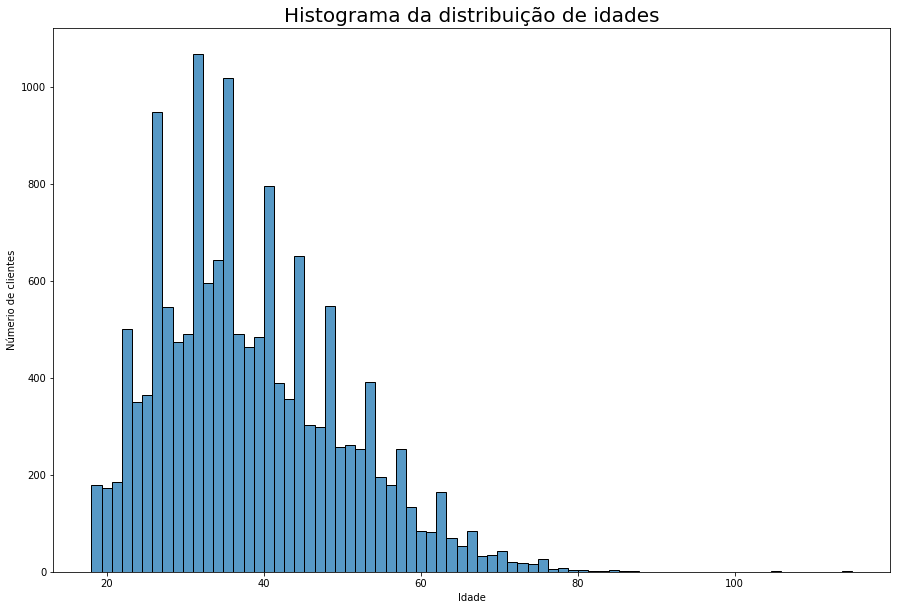

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(data=pre_approv, x='age')
ax.set_xlabel("Idade",fontsize=10);
ax.set_ylabel("Númerio de clientes",fontsize=10);
plt.title("Histograma da distribuição de idades", size = 20);

Existem uns outliers com idade acima de 100 anos. Vamos visualizar essas entradas

In [ ]:
pre_approv[pre_approv['age'] >100]

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,expired_debts,banking_debts,commercial_debts,protests,informed_restriction,monthly_payment,informed_purpose,auto_brand,auto_model,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level,income_cat,payment_cat,auto_brand_cat,auto_model_cat,informed_cat
2281,170130,105,2850.0,33000.0,5000.00,turvo,SC,0.0,0,0,0,0,0,0,0,541.67,contas,renault,CLIO RN/ALIZÉ/EXPR./1.0 HI-POWER 16V 5P,2016,1,0,0,search,8893XXXX,/emprestimos/solicitar,PersonalLoan,male,ni,"Ensino médio completo (antigo 2º grau, secundá...",2,2,1,1,1
31194,119244,115,1800.0,190001.0,12310.03,guaíra,SP,9000.0,0,0,0,0,0,0,0,540.00,quitar dividas,fiat,PALIO ELX 1.0 FIRE/30 ANOS F. FLEX 8V 4P,2008,1,1,0,remarketing,1479XXXX,/emprestimos/solicitar,PersonalLoan,male,c,"Ensino médio completo (antigo 2º grau, secundá...",2,2,1,1,1
31842,117651,115,8000.0,30000.0,27000.00,rio de janeiro,RJ,21000.0,0,0,0,0,0,0,0,1184.40,expandir negócio,nissan,SENTRA S 2.0/ 2.0 FLEX FUEL 16V AUT.,2009,1,0,0,emailaffiliates,2053XXXX,/emprestimos/solicitar,PersonalLoan,male,ni,não informado,6,3,1,1,1


São apenas 3 e possuem idades improváveis, e todos não foram aceitos. Vamos descartá-los

In [ ]:
pre_approv = pre_approv[pre_approv['age'] <=100]

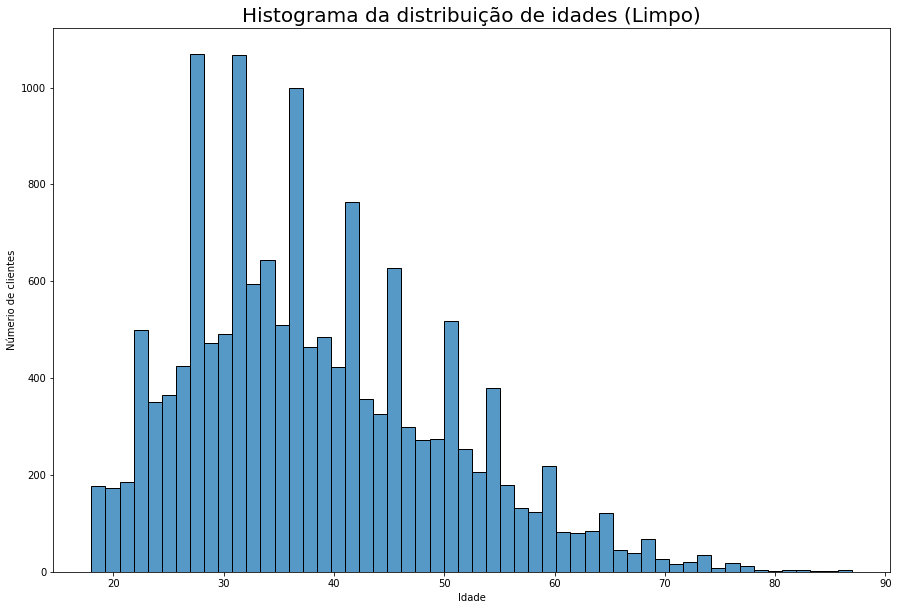

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(data=pre_approv, x='age')
ax.set_xlabel("Idade",fontsize=10);
ax.set_ylabel("Númerio de clientes",fontsize=10);
plt.title("Histograma da distribuição de idades (Limpo)", size = 20);

### 5.1.2) Aprovação versus renda mensal

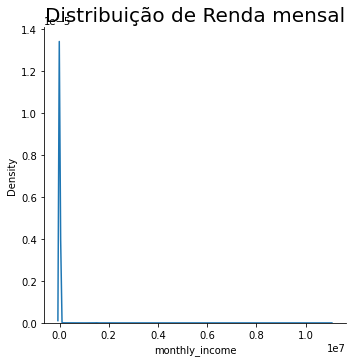

In [ ]:
sns.displot(pre_approv, x='monthly_income',kind='kde')
ax.set_xlabel("Renda mensal",fontsize=10);
ax.set_ylabel("Númerio de clientes",fontsize=10);
plt.title("Distribuição de Renda mensal", size = 20);

Vemos que temos vários outilers. Vamos tentar visualizar essas rendas mensais altas

In [ ]:
salario_outliers = pre_approv[pre_approv['income_cat'] ==  7]
salario_outliers

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,expired_debts,banking_debts,commercial_debts,protests,informed_restriction,monthly_payment,informed_purpose,auto_brand,auto_model,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level,income_cat,payment_cat,auto_brand_cat,auto_model_cat,informed_cat
29,173429,43,10000.0,24985.0,6000.0,são bernardo do campo,SP,0.000000,0,0,0,0,0,0,0,671.199132,não informado,nissan,MARCH S 1.0 16V FLEX FUEL 5P,2013,1,0,1,affiliates,9660XXXX,/emprestimos/garantia-veiculo/guia-bolso,HomePage,não mencionar,ni,Educação superior completa,7,2,1,1,0
40,173413,39,11400.0,15300.0,13770.0,suzano,SP,0.000000,0,0,0,0,0,0,0,726.750000,investimento,citroën,XSARA PICASSO GLX /BRASIL/ETOILE 2.0 MEC,2004,1,0,0,display,8663XXXX,/emprestimos/garantia-veiculo/solicitar,HomePage,male,ni,Educação superior completa,7,2,1,1,1
46,173405,46,15000.0,35000.0,25000.0,rio de janeiro,RJ,8288.321851,0,0,0,0,0,0,0,1041.670000,despesas gerais,hyundai,TUCSON 2.0 16V AUT.,2011,1,0,1,search,2262XXXX,/emprestimos/solicitar,PersonalLoan,male,ni,Educação superior completa,7,3,1,1,1
48,173402,36,3500000.0,22000.0,6000.0,cabo frio,RJ,0.000000,0,0,0,0,0,0,0,194.120000,envestimento,audi,A1 SPORT 1.4 TFSI 185CV 3P S-TRONIC,2013,1,0,0,direct,2892XXXX,/,HomePage,male,ni,4ª série completa do ensino fundamental (antig...,7,1,1,1,1
59,173385,50,10000.0,35000.0,31500.0,mesquita,RJ,8288.321851,0,0,0,0,0,0,0,2100.000000,investimento,gm - chevrolet,MERIVA PREM.EASYTRONIC 1.8 FLEXPOWER 5P,2012,1,0,0,remarketing,2658XXXX,/emprestimos/garantia-veiculo/solicitar,HomePage,male,ni,4ª série completa do ensino fundamental (antig...,7,5,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34901,98527,49,12000.0,78000.0,35000.0,arujá,SP,45000.000000,0,0,0,0,0,0,0,1536.860000,troca de carro,honda,CITY SEDAN EX 1.5 FLEX 16V 4P AUT.,2014,1,0,0,remarketing,7411XXXX,/emprestimos/garantia-veiculo/solicitar,HomePage,male,c,não informado,7,4,1,1,1
34967,98414,55,15000.0,45000.0,30500.0,fortaleza,CE,15000.000000,0,0,0,0,0,0,0,1337.930000,quitar outras dívidas,gm - chevrolet,SPIN LTZ 1.8 8V ECONO.FLEX 5P AUT.,2013,1,0,0,remarketing,6081XXXX,/emprestimos/garantia-veiculo/solicitar,HomePage,male,c,Educação superior completa,7,3,1,1,1
34990,98373,34,11500.0,30000.0,27000.0,curitiba,PR,8288.321851,1,0,0,1,1,0,1,1184.400000,quitar as dúvidas e limpar o nome,nissan,VERSA S 1.6 16V FLEX FUEL MEC. 4P,2013,1,0,0,affiliates,8265XXXX,/emprestimos/garantia-veiculo/solicitar,HomePage,female,ni,Educação superior completa,7,3,1,1,1
34996,98366,26,30000.0,39560.0,5000.0,brasília,DF,0.000000,0,0,0,0,0,0,0,493.950000,pagar dividaz,ford,FIESTA 1.5 16V FLEX MEC. 5P,2014,1,0,0,search,7168XXXX,/,HomePage,male,m,não informado,7,1,1,1,1


Vamos analisar quantos outliers foram mandados para análise

In [ ]:
salario_outliers['sent_to_analysis'].value_counts()

0    1183
1     636
Name: sent_to_analysis, dtype: int64

In [ ]:
print("Média do renda mensal dos outliers:", round(salario_outliers.monthly_income.mean(),2))
print("Renda mensal mínima dos outliers:", salario_outliers.monthly_income.min())
print("Renda mensal máxima dos outliers:", salario_outliers.monthly_income.max())
print("Desvio padrão da renda mensal outliers:",round(salario_outliers.monthly_income.std(),2))

Média do renda mensal dos outliers: 62647.88
Renda mensal mínima dos outliers: 9050.0
Renda mensal máxima dos outliers: 11000000.0
Desvio padrão da renda mensal outliers: 438498.93


In [ ]:
salario_normal = pre_approv[pre_approv['income_cat'] !=  7]

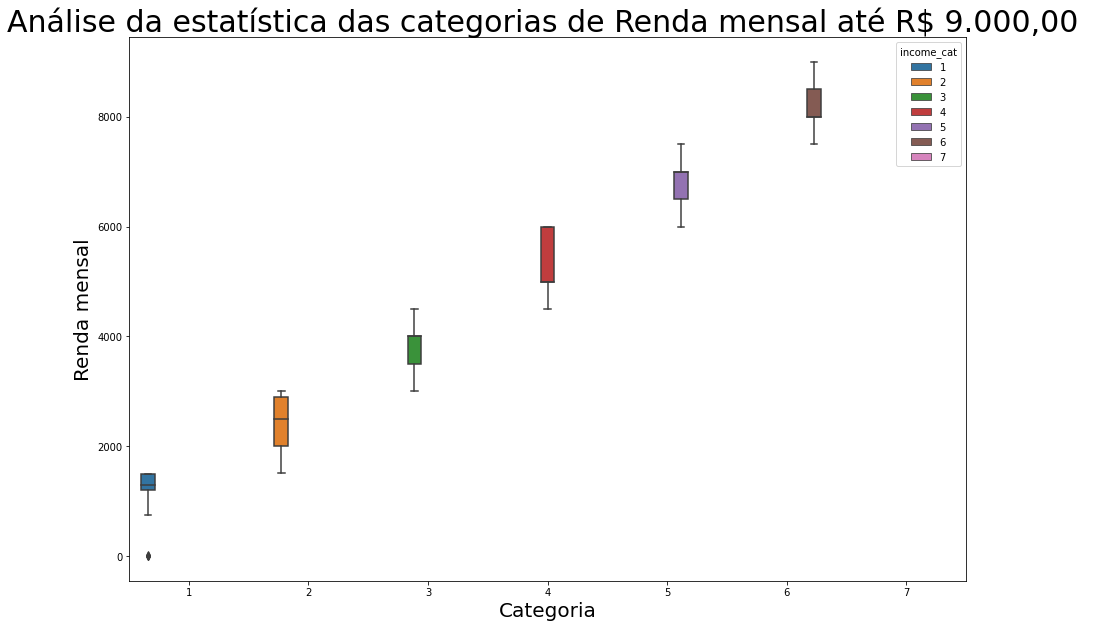

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.boxplot( x ='income_cat', y ='monthly_income', data = salario_normal, hue ='income_cat')

ax.set_xlabel("Categoria",fontsize=20);
ax.set_ylabel("Renda mensal",fontsize=20);

plt.title("Análise da estatística das categorias de Renda mensal até R$ 9.000,00 ", size = 30);

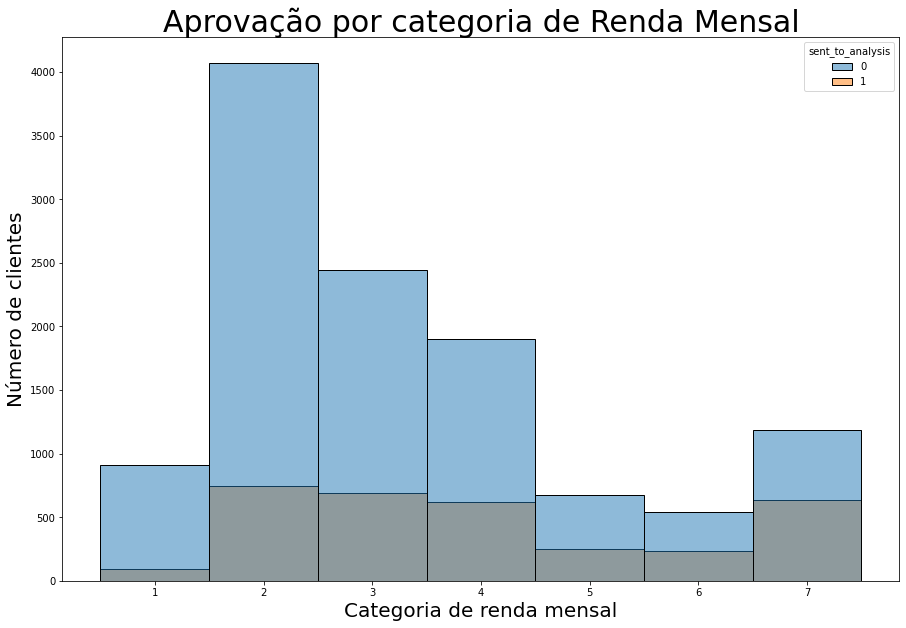

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(data=pre_approv, x='income_cat', hue = 'sent_to_analysis')

ax.set_xlabel("Categoria de renda mensal",fontsize=20);
ax.set_ylabel("Número de clientes",fontsize=20);

plt.title("Aprovação por categoria de Renda Mensal", size = 30);

In [ ]:
 income_total = pre_approv['income_cat'].value_counts()
 income_total = pd.DataFrame(income_total)

In [ ]:
income = pre_approv[['income_cat','sent_to_analysis']].groupby('income_cat').sum()
income['total'] = income_total['income_cat']
income['percent'] = income['sent_to_analysis']/income['total']*100
income

,sent_to_analysis,total,percent
income_cat,,,
1,93,1006,9.244533
2,749,4820,15.539419
3,689,3134,21.984684
4,618,2518,24.543288
5,249,921,27.035831
6,235,778,30.205656
7,636,1819,34.964266


Na tabela acima temos a proporção de aprovados por categoria e vemmos que as Categorias 1 e 2 tem menos chances de serem aprovadas

In [ ]:
salario_normal = pre_approv[pre_approv['monthly_income']<=20000]

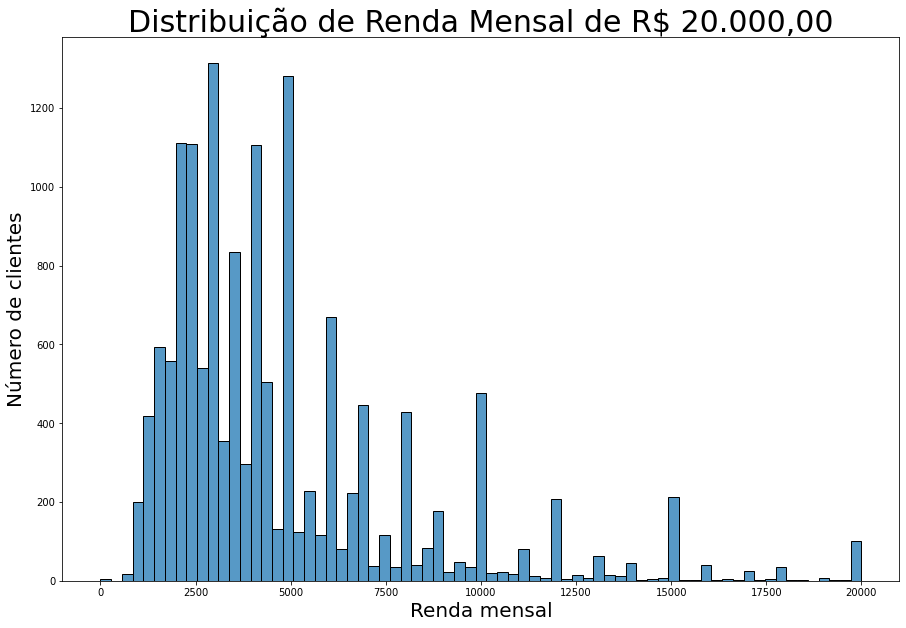

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(data=salario_normal, x='monthly_income')
ax.set_xlabel("Renda mensal",fontsize=20);
ax.set_ylabel("Número de clientes",fontsize=20);

plt.title("Distribuição de Renda Mensal de R$ 20.000,00", size = 30);

### 5.1.3) Aprovação por estado

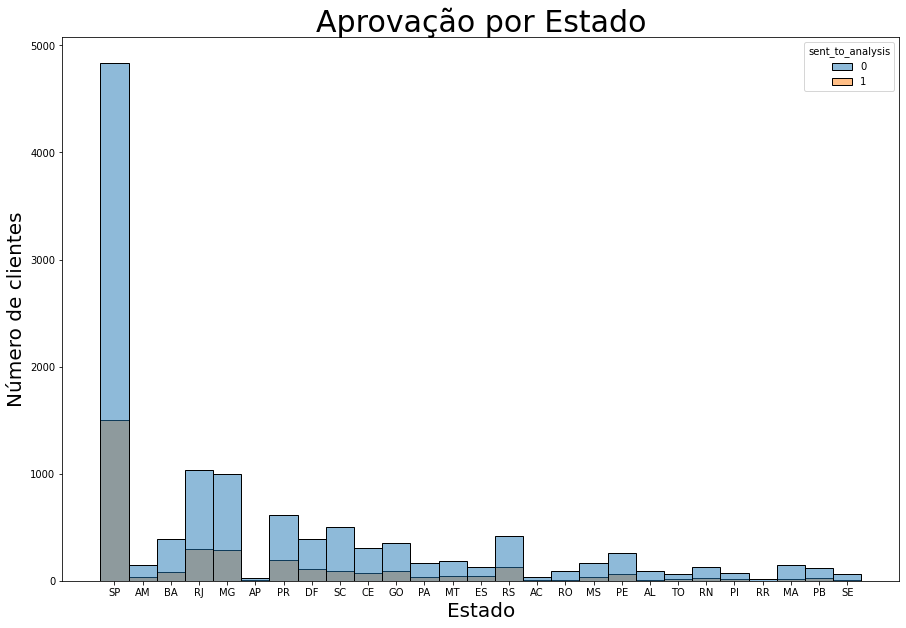

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(data=pre_approv, x='state', hue='sent_to_analysis')
ax.set_xlabel("Estado",fontsize=20);
ax.set_ylabel("Número de clientes",fontsize=20);

plt.title("Aprovação por Estado", size = 30);

Vemos que a aprovaçao é maior em São Paulo, porém é o estado que mais possui clientes. Podemos verificar isso calculando a proporção de aprovados por estado

In [ ]:
state_total = pre_approv['state'].value_counts()
state_total = pd.DataFrame(state_total)

In [ ]:
state = pre_approv[['state','sent_to_analysis']].groupby('state').sum()
state['total'] = state_total['state']
state['percent'] = state['sent_to_analysis']/state['total']*100
state

,sent_to_analysis,total,percent
state,,,
AC,3,35,8.571429
AL,11,104,10.576923
AM,32,179,17.877095
AP,11,40,27.500000
BA,86,476,18.067227
CE,70,372,18.817204
DF,109,496,21.975806
ES,48,173,27.745665
GO,95,448,21.205357


### 5.1.4) Aprovação versus Restrição

A existência de uma restrição é uma infomração muito relevante na tomada de decisão de um empréstimo.

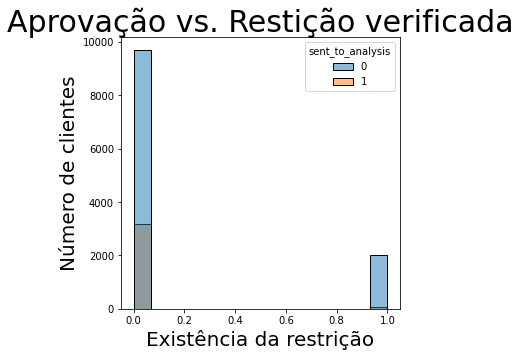

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(data=pre_approv, x='verified_restriction', hue='sent_to_analysis')
ax.set_xlabel("Existência da restrição",fontsize=20);
ax.set_ylabel("Número de clientes",fontsize=20);
plt.title("Aprovação vs. Restição verificada", size = 30);

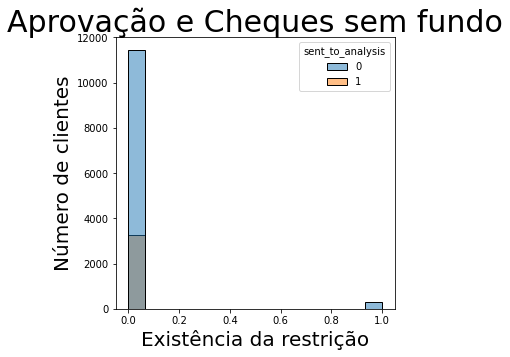

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(data=pre_approv, x='dishonored_checks', hue='sent_to_analysis')
ax.set_xlabel("Existência da restrição",fontsize=20);
ax.set_ylabel("Número de clientes",fontsize=20);
plt.title("Aprovação e Cheques sem fundo", size = 30);

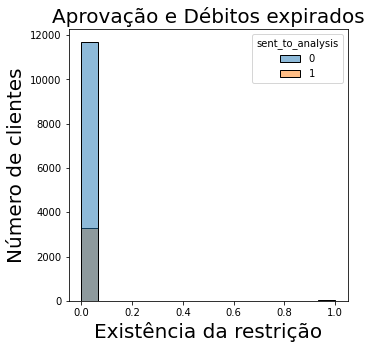

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(data=pre_approv, x='expired_debts', hue='sent_to_analysis')
ax.set_xlabel("Existência da restrição",fontsize=20);
ax.set_ylabel("Número de clientes",fontsize=20);
plt.title("Aprovação e Débitos expirados", size = 20);

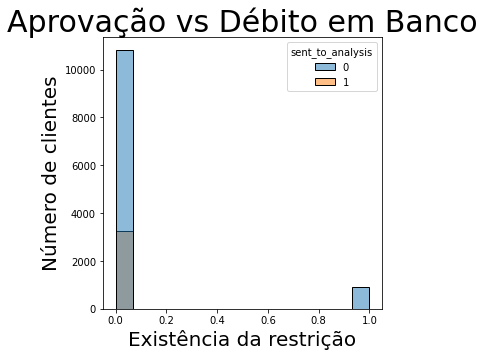

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(data=pre_approv, x='banking_debts', hue='sent_to_analysis')
ax.set_xlabel("Existência da restrição",fontsize=20);
ax.set_ylabel("Número de clientes",fontsize=20);
plt.title("Aprovação vs Débito em Banco", size = 30);

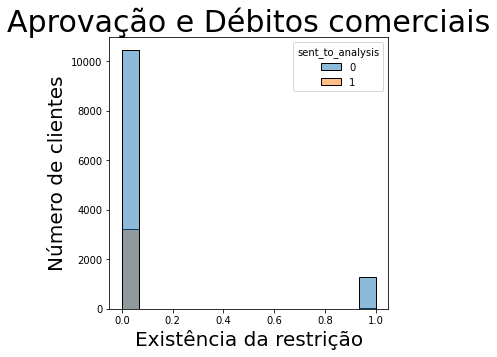

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(data=pre_approv, x='commercial_debts', hue='sent_to_analysis')
ax.set_xlabel("Existência da restrição",fontsize=20);
ax.set_ylabel("Número de clientes",fontsize=20);
plt.title("Aprovação e Débitos comerciais", size = 30);

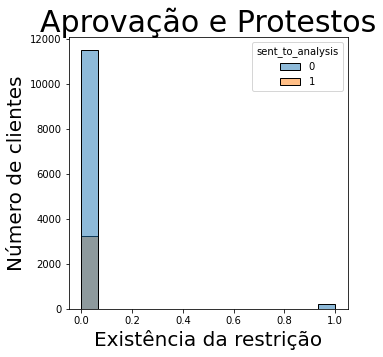

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(data=pre_approv, x='protests', hue='sent_to_analysis')
ax.set_xlabel("Existência da restrição",fontsize=20);
ax.set_ylabel("Número de clientes",fontsize=20);
plt.title("Aprovação e Protestos", size = 30);

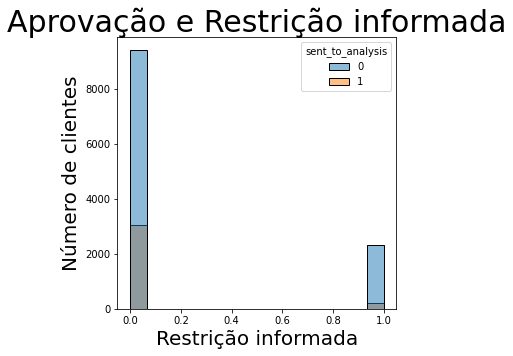

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(data=pre_approv, x='informed_restriction', hue='sent_to_analysis')
ax.set_xlabel("Restrição informada",fontsize=20);
ax.set_ylabel("Número de clientes",fontsize=20);
plt.title("Aprovação e Restrição informada", size = 30);

Podemos inferir pelos gráficos acima que clientes sem restrições tem mais chances de serem aprovados

### 5.1.5) Aprovação versus Carro

In [ ]:
pre_approv[['auto_brand_cat','sent_to_analysis']].groupby('auto_brand_cat').count()

,sent_to_analysis
auto_brand_cat,
1,14996


In [ ]:
pre_approv[['auto_brand_cat', 'auto_model_cat','sent_to_analysis']].groupby('auto_brand_cat').count()

,auto_model_cat,sent_to_analysis
auto_brand_cat,,
1,14996,14996


Vemos que todos os pré aprovados tem carro, sendo um pré-requsito mínimo para ser considerado pré-aprovado.

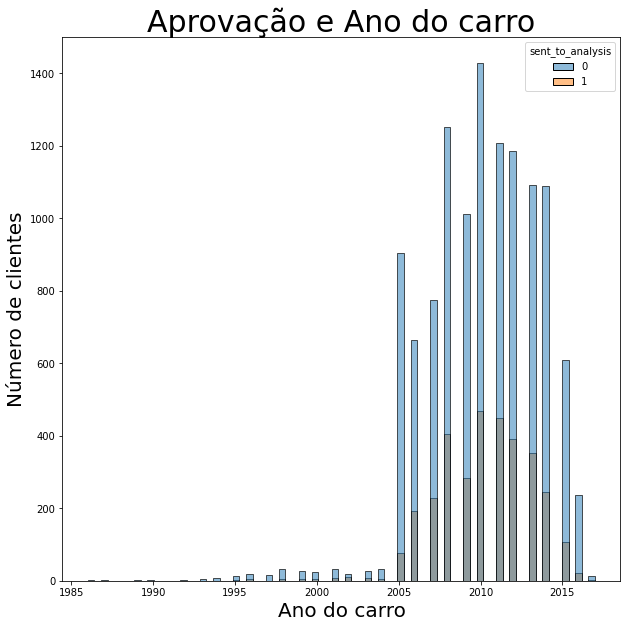

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(data=pre_approv, x='auto_year', hue='sent_to_analysis')
ax.set_xlabel("Ano do carro",fontsize=20);
ax.set_ylabel("Número de clientes",fontsize=20);
plt.title("Aprovação e Ano do carro", size = 30);

### 5.1.6) Aprovação versus Pagamento mensal

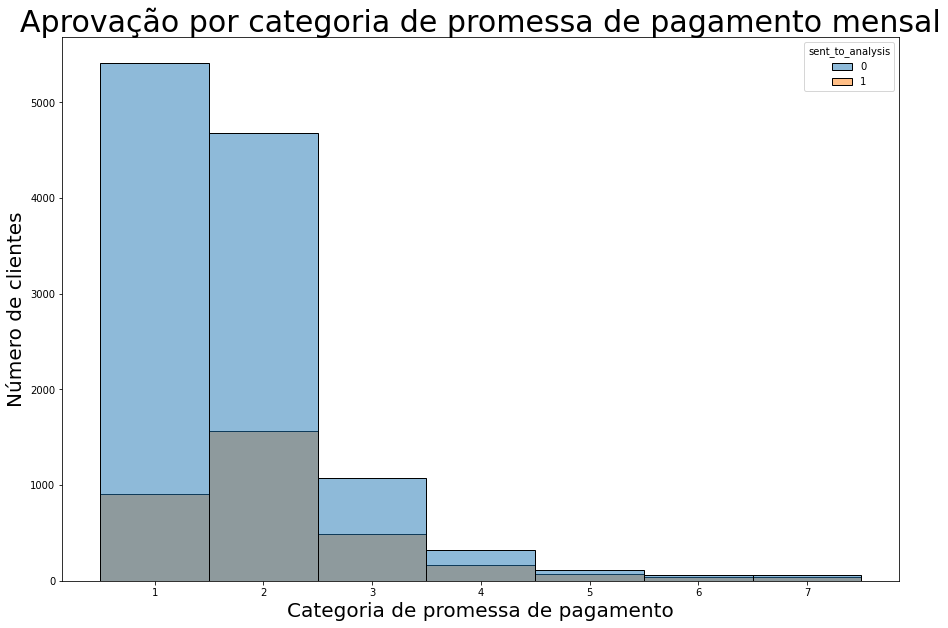

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(data=pre_approv, x='payment_cat', hue = 'sent_to_analysis')
ax.set_xlabel("Categoria de promessa de pagamento",fontsize=20);
ax.set_ylabel("Número de clientes",fontsize=20);
plt.title("Aprovação por categoria de promessa de pagamento mensal", size = 30);

### 5.1.7) Aprovação versus Propósito de pagamento

As pessoas tem muitos motivos para tirarem um empréstimo. Porém, aquelas que possuem um destino claro para o dinheiro, tem maiores chances de honrarem com o pagamento, portanto, tem mais chance de conseguirem o empréstimo. Ao invés de analisar a coluna `informed_purpose`, vamos analisar a coluna criada nesse caderno chamada `informed_cat`, onde contém a infomração que o cliente forneceu ou não a motivação do empréstimo.

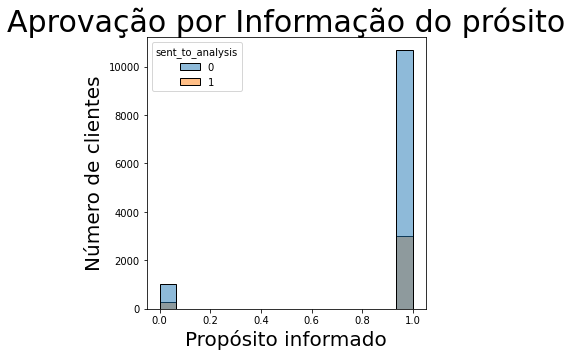

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(data=pre_approv, x='informed_cat', hue = 'sent_to_analysis')
ax.set_xlabel("Propósito informado",fontsize=20);
ax.set_ylabel("Número de clientes",fontsize=20);
plt.title("Aprovação por Informação do prósito", size = 30);

### 5.1.8) Outras categorias

Essas categorias não influenciam para a decisão da análise do cliente. Percebe-se porque o percentual de aprovados por categoria é semelhante, indicando que existem mais aprovados em tal maneira de acessar porque mais pessoas acesam por aquele canal.

Entretanto, esses dados são importantes para saber se a estratégia de captação de cliente está eficiente e onde melhor podemos captá-los

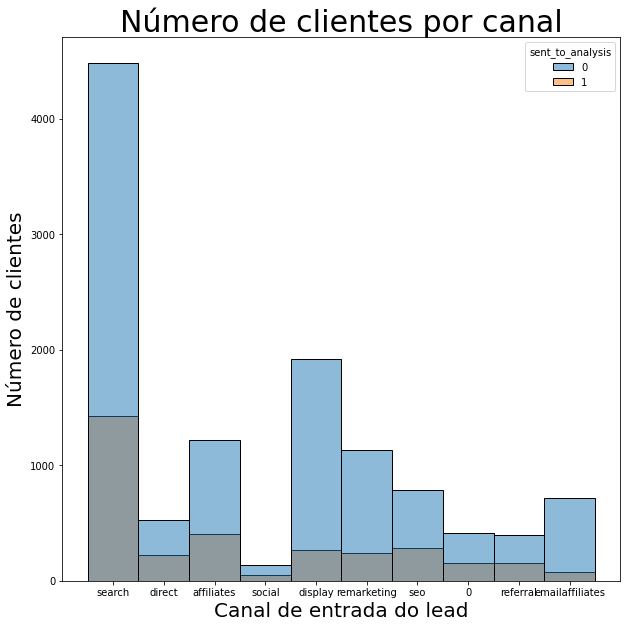

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(data=pre_approv, x='channel', hue = 'sent_to_analysis')
ax.set_xlabel("Canal de entrada do lead",fontsize=20);
ax.set_ylabel("Número de clientes",fontsize=20);
plt.title("Número de clientes por canal", size = 30);

In [ ]:
 channel_total = pre_approv['channel'].value_counts()
 channel_total = pd.DataFrame(channel_total)

In [ ]:
channel = pre_approv[['channel','sent_to_analysis']].groupby('channel').sum()
channel['total'] = channel_total['channel']
channel['percent'] = channel['sent_to_analysis']/channel['total']
channel

,sent_to_analysis,total,percent
channel,,,
0,151,565,0.267257
affiliates,406,1626,0.249692
direct,222,748,0.296791
display,267,2187,0.122085
emailaffiliates,73,788,0.092640
referral,150,544,0.275735
remarketing,239,1371,0.174325
search,1425,5908,0.241198
seo,288,1071,0.268908


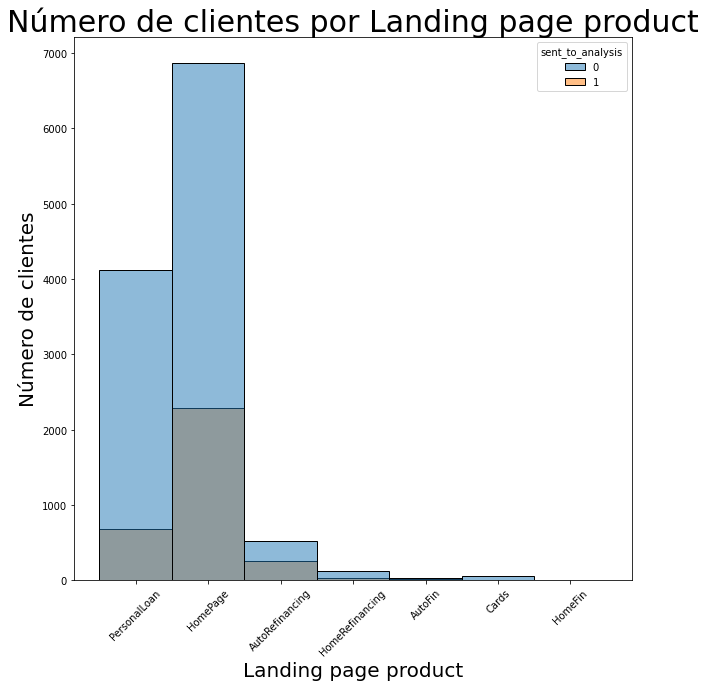

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(data=pre_approv, x='landing_page_product', hue = 'sent_to_analysis')
ax.set_xlabel("Landing page product",fontsize=20);
ax.set_ylabel("Número de clientes",fontsize=20);
plt.title("Número de clientes por Landing page product", size = 30);
plt.xticks(rotation=45);

In [ ]:
land_page_total = pre_approv['landing_page_product'].value_counts()
land_page_total = pd.DataFrame(land_page_total)
land_page = pre_approv[['landing_page_product','sent_to_analysis']].groupby('landing_page_product').sum()
land_page['total'] = land_page_total['landing_page_product']
land_page['percent'] = land_page['sent_to_analysis']/land_page['total']
land_page

,sent_to_analysis,total,percent
landing_page_product,,,
AutoFin,16,45,0.355556
AutoRefinancing,259,776,0.333763
Cards,3,59,0.050847
HomeFin,0,2,0.000000
HomePage,2283,9154,0.249399
HomeRefinancing,31,158,0.196203
PersonalLoan,677,4802,0.140983


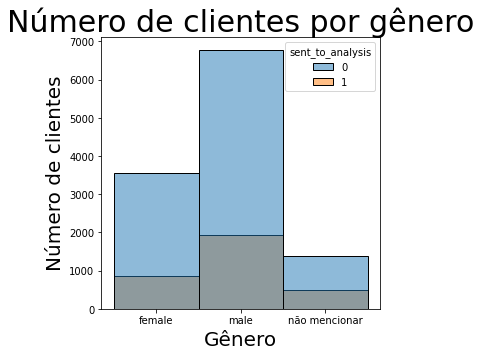

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(data=pre_approv, x='gender', hue = 'sent_to_analysis')
ax.set_xlabel("Gênero",fontsize=20);
ax.set_ylabel("Número de clientes",fontsize=20);
plt.title("Número de clientes por gênero", size = 30);

In [ ]:
sex_total = pre_approv['gender'].value_counts()
sex_total = pd.DataFrame(sex_total)
sex = pre_approv[['gender','sent_to_analysis']].groupby('gender').sum()
sex['total'] = sex_total['gender']
sex['percent'] = sex['sent_to_analysis']/sex['total']
sex

,sent_to_analysis,total,percent
gender,,,
female,850,4404,0.193006
male,1922,8700,0.220920
não mencionar,497,1892,0.262685


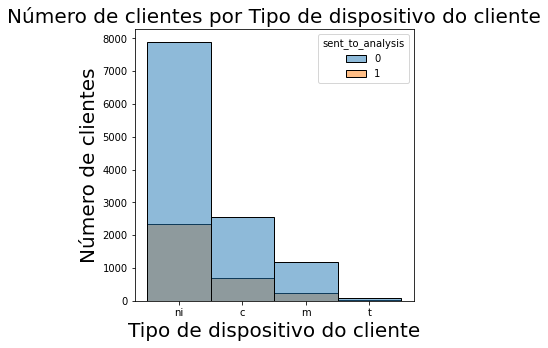

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(data=pre_approv, x='utm_term', hue = 'sent_to_analysis')
ax.set_xlabel("Tipo de dispositivo do cliente",fontsize=20);
ax.set_ylabel("Número de clientes",fontsize=20);
plt.title("Número de clientes por Tipo de dispositivo do cliente", size = 20);

In [ ]:
utm_total = pre_approv['utm_term'].value_counts()
utm_total = pd.DataFrame(utm_total)
utm = pre_approv[['utm_term','sent_to_analysis']].groupby('utm_term').sum()
utm['total'] = utm_total['utm_term']
utm['percent'] = utm['sent_to_analysis']/utm['total']
utm

,sent_to_analysis,total,percent
utm_term,,,
c,688,3256,0.211302
m,229,1426,0.160589
ni,2333,10223,0.228211
t,19,91,0.208791


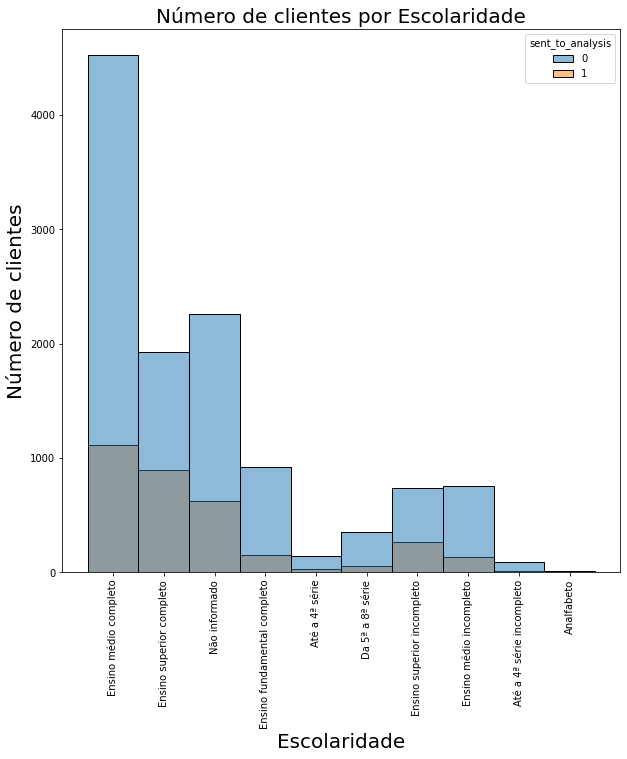

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(data=pre_approv, x='education_level', hue = 'sent_to_analysis')
ax.set_xlabel("Escolaridade",fontsize=20);
ax.set_ylabel("Número de clientes",fontsize=20);
plt.title("Número de clientes por Escolaridade", size = 20);
plt.xticks(np.arange(10),('Ensino médio completo', 'Ensino superior completo', 'Não informado', 
           'Ensino fundamental completo', 'Até a 4ª série','Da 5ª a 8ª série',
           'Ensino superior incompleto','Ensino médio incompleto',
           'Até a 4ª série incompleto', 'Analfabeto'))
plt.xticks(rotation=90);

## 5.2) Selecionando as Features mais relevantes

Vamos descartar como feature relevante da informed_purpose e auto_model. Essas duas colunas possuem informações pouco padronizadas, mas elas serão importantes para o processo de análise feito por um funcionário posteriormente.
 
Landing_page também possui informações únicas demais e não relevantes para o processo em si e mais para estudo das estratégias de marketing
 
A coluna cidades possui muitas variáveis, sendo impossível categorizá-las.

Pre-approved não será mais necessária, porque já pré selecionamos as pessoas.

In [ ]:
pre_approv = pre_approv.drop(['id','city','informed_purpose','pre_approved','channel','zip_code',
                              'zip_code', 'landing_page', 'landing_page_product','utm_term'],axis = 1)

### 5.2.1) Matriz de Correlação

A atriz de Correlação é uma tabela que mostra a correlação entre as variáveis no conjunto de dados. Essencialmente, quanto mais altos os números, mais correlacionadas estão as duas variáveis.

In [ ]:
pre_approv.corr()

,age,monthly_income,collateral_value,loan_amount,collateral_debt,verified_restriction,dishonored_checks,expired_debts,banking_debts,commercial_debts,protests,informed_restriction,monthly_payment,auto_year,form_completed,sent_to_analysis,auto_brand_cat,auto_model_cat,informed_cat
age,1.000000,0.002028,-0.007621,0.104839,0.010195,0.003289,0.034845,0.008394,0.000752,-0.010222,0.024658,0.004169,-0.003948,0.020434,0.024523,0.065440,NaN,NaN,0.068453
monthly_income,0.002028,1.000000,0.084925,0.020875,0.003950,-0.001911,0.000839,-0.000663,0.005202,-0.002953,-0.005169,-0.000663,0.000053,0.003133,0.014277,-0.007998,NaN,NaN,-0.000272
collateral_value,-0.007621,0.084925,1.000000,0.028514,0.081269,-0.006369,-0.002994,-0.000956,-0.006114,-0.003668,-0.002884,0.012825,0.001098,0.016787,0.002870,-0.003991,NaN,NaN,0.005832
loan_amount,0.104839,0.020875,0.028514,1.000000,0.003632,-0.022053,0.021457,0.010725,-0.005118,-0.020422,-0.005645,-0.059535,0.021881,0.188232,0.038424,0.111533,NaN,NaN,-0.021466
collateral_debt,0.010195,0.003950,0.081269,0.003632,1.000000,-0.000622,0.002420,-0.000222,0.002591,-0.001560,-0.000524,-0.001641,-0.000307,0.014045,0.012836,-0.012704,NaN,NaN,0.010200
verified_restriction,0.003289,-0.001911,-0.006369,-0.022053,-0.000622,1.000000,0.323942,0.127662,0.617572,0.755618,0.298192,0.478368,-0.004800,-0.028807,0.008007,-0.174896,NaN,NaN,0.056640
dishonored_checks,0.034845,0.000839,-0.002994,0.021457,0.002420,0.323942,1.000000,0.096958,0.298563,0.250448,0.194736,0.236062,-0.000611,0.001134,0.031429,-0.071122,NaN,NaN,0.034561
expired_debts,0.008394,-0.000663,-0.000956,0.010725,-0.000222,0.127662,0.096958,1.000000,0.094658,0.061210,0.035944,0.076417,-0.000138,0.012825,0.008335,-0.027305,NaN,NaN,0.016047
banking_debts,0.000752,0.005202,-0.006114,-0.005118,0.002591,0.617572,0.298563,0.094658,1.000000,0.332436,0.175659,0.405803,-0.002866,-0.016049,0.016751,-0.128760,NaN,NaN,0.059579
commercial_debts,-0.010222,-0.002953,-0.003668,-0.020422,-0.001560,0.755618,0.250448,0.061210,0.332436,1.000000,0.166963,0.371747,-0.003993,-0.026959,-0.010061,-0.136795,NaN,NaN,0.037071


(19.5, -0.5)

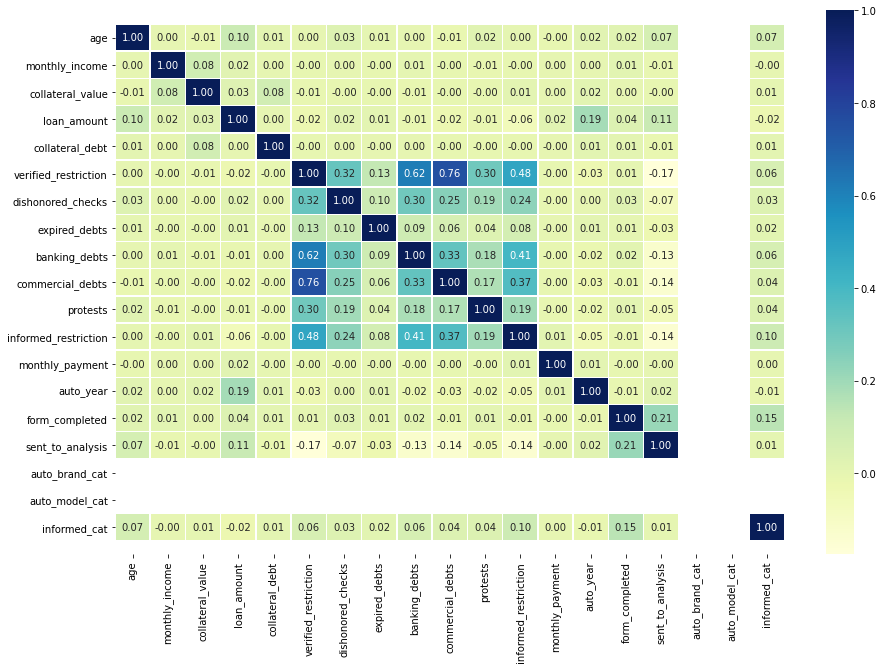

In [ ]:
# Plotando a matriz de correlação
corr_matrix = pre_approv.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Auto_brand_cat e auto_model_cat não nos dão informações relevantes, porque quando selecionamos os pré-aprovados, todos tem carro. Essas categorias foram boas para selecionar quando lidamos com o dataset inteiro, seriam relevantes se quiséssemos medir a chance do cliente ser pré aprovado.


In [ ]:
pre_approv.drop(['auto_brand_cat', 'auto_model_cat'],axis = 1, inplace=True)

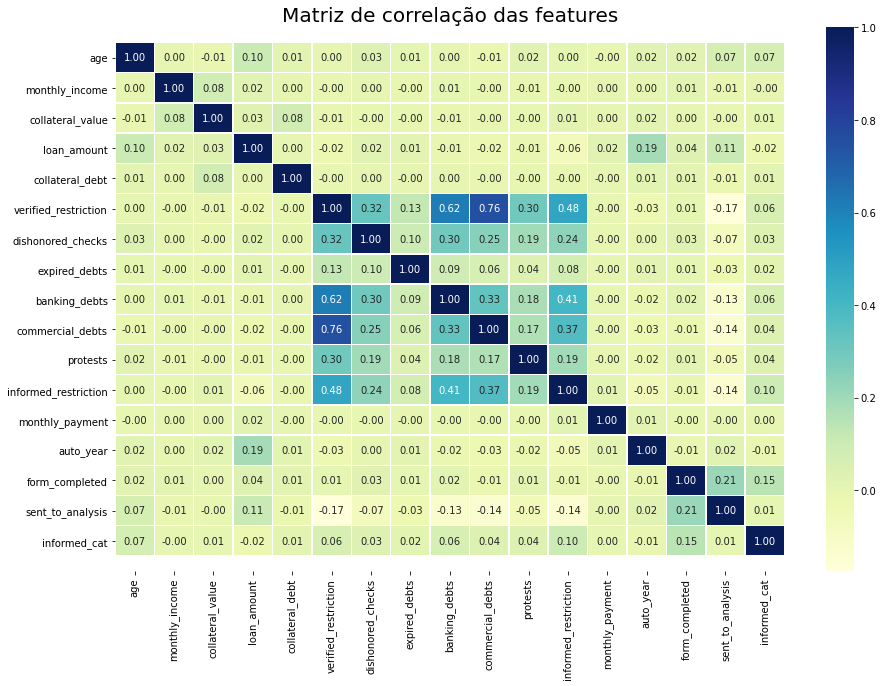

In [ ]:
# Plotando a matriz de correlação atualizada
corr_matrix = pre_approv.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Matriz de correlação das features', fontsize=20);

## 5.3) Transformando Features categoricas em número

As maquinas não entendem o formato string, então vamos transformar essas informações em categorias numéricas, para isso utilizaremos o `OneHotEncoder()`

Além disso temos que normalizar os dados numéricos contínuos (renda mensal, pagamento mensal), chamado **Feature Scaling**. O método escolhido foi o `MinMaxScaler` que consiste em subtrair o valor mínimo da feature e o dividir pelo intervalo que é a diferença entre o valor máximo e mínimo original. Ele redimensiona o conjunto de dados para o intervalo de 0 e 1. 

In [ ]:
#Categorias numericas
pre_approv_num = pre_approv.drop(["state", "auto_brand", "auto_model","gender",'education_level','income_cat','payment_cat'], axis=1)

In [ ]:
pre_approv.columns

Index(['age', 'monthly_income', 'collateral_value', 'loan_amount', 'state',
       'collateral_debt', 'verified_restriction', 'dishonored_checks',
       'expired_debts', 'banking_debts', 'commercial_debts', 'protests',
       'informed_restriction', 'monthly_payment', 'auto_brand', 'auto_model',
       'auto_year', 'form_completed', 'sent_to_analysis', 'gender',
       'education_level', 'income_cat', 'payment_cat', 'informed_cat'],
      dtype='object')

In [ ]:
num_pipeline = Pipeline([('min_max', MinMaxScaler())])

In [ ]:
num_attribs = list(pre_approv_num)
cat_attribs = ["state", "auto_brand", "auto_model","gender",'education_level','income_cat','payment_cat']

full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs),("cat", OneHotEncoder(), cat_attribs)])

approv_clean_prepared = full_pipeline.fit_transform(pre_approv)

In [ ]:
X = approv_clean_prepared
y= pre_approv['sent_to_analysis']

# 6) Machine Learning

Quando se trata de classificação, existem vários algoritmos diferentes à disposição. Aqui está uma rápida recapitulação do que cada algoritmo faz e como ele se diferencia dos outros:

- **Regressão logística**: este algoritmo usa regressão para ***prever a probabilidade contínua*** de uma amostra de dados (de 0 a 1) e, em seguida, classifica essa amostra para o alvo mais provável (0 ou 1).

- **K-Neighbours**: este algoritmo assume que os pontos de dados que estão próximos uns dos outros pertencem à mesma classe. Particularmente, ele classifica o alvo (0 ou 1) de uma amostra de dados por ***uma pluralidade de votos dos vizinhos*** que estão próximos em distância dele.

- **SVC**: este algoritmo faz classificações ***definindo um domínio de decisão*** e, em seguida, classifica a amostra de dados para o destino (0 ou 1) vendo em que lado do domínio ele cai. Essencialmente, o algoritmo visa maximizar a distância entre o limite de decisão e os pontos em cada classe para diminuir a chance de uma classificação falsa.

- **Random Forest**: este algoritmo é uma técnica de ensemble desenvolvida a partir da Árvore de Decisão (Decision Tree), na qual envolve várias árvores de decisão que funcionam juntas. Particularmente, Random Forest fornece essa amostra de dados para cada uma das árvores de decisão e ***retorna a classificação mais popular*** para atribuir o destino a essa amostra de dados. Este algoritmo ajuda a evitar overfitting que pode ocorrer na árvore de decisão, pois agrega a classificação de várias árvores em vez de uma.

## 6.1) Train e test split

Para utilizarmos os algoritmos listados anteriormente, temos que embaralhar os dados e separálos em conjuntos de treino (X_train,y_train) e conjuntos de teste (X_test,y_test) para poder medir a performance do modelo.

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [ ]:
X_train.shape,X_test.shape

((11996, 1793), (3000, 1793))

## 6.2) Escolhendo o Modelo

Vamos criar uma função chamada `fit_and_score` que retorna a matriz de confusão e a acurácia do modelo.

Temos que maximizar a diagonal principal, onde estão os verdadeiros positivos (**T**rue **P**ositive) e os verdadeiros negativos (**T**rue **N**egative).

Já a diagonal secundária, são as prediçoes erradas do modelo, os falsos positivos (**F**alse **P**ositive) e os falsos negativos (**F**alse **N**egative).

No problema em questão, não queremos reprovar um cliente positivo, mas queremos triar um cliente que claramente não será aprovado. Portanto, queremos um modelo com poucos falsos negativos.

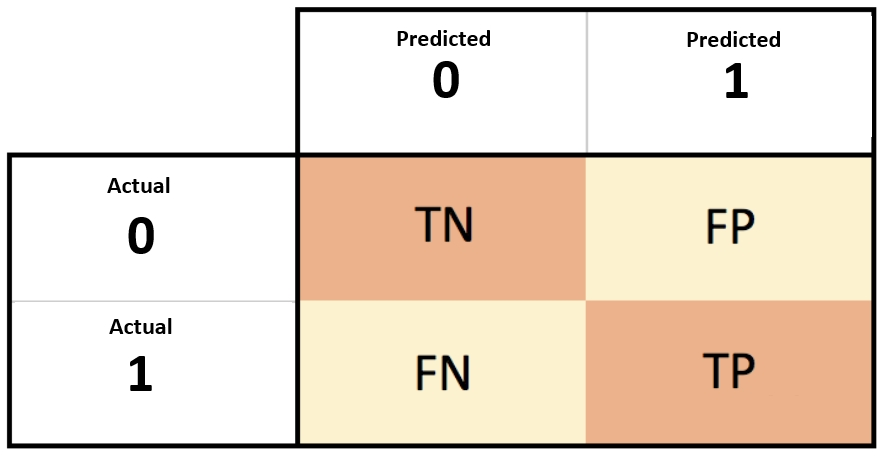

In [ ]:
# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
        #Plotando a Detecção do Ataque na Matrix de Confusão
        y_true = y_test
        y_pred = model.predict(X_test)
        recall = recall_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cmn, annot=True, fmt ='.4f',cmap="YlGnBu")
        plt.xlabel('Predict')
        plt.ylabel('True');
    return model_scores

In [ ]:
lr = LogisticRegression()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
svc = svm.SVC(kernel='linear')

In [ ]:
models = {"Logistic Regression": lr,
          "KNN": knn,
          "Random Forest": rf,
          "SVM Classifier": svc}

### 6.2.1) Logistic Regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'Logistic Regression': 0.9876666666666667}

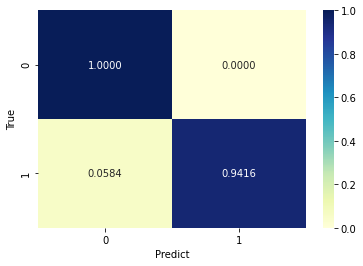

In [ ]:
model_scores = fit_and_score(models={"Logistic Regression":LogisticRegression(C=0.1,max_iter = 3)},
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

In [ ]:
# Cross-validated accuracy
cv_acc_lr = cross_val_score(lr,
                         X,
                         y,
                         cv=5,
                         scoring="precision")
cv_acc_lr

array([1., 1., 1., 1., 1.])

Vemos que a Regressão logística é muito boa para selecionar quem não deve ir para análise

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'Logistic Regression': 0.9976666666666667}

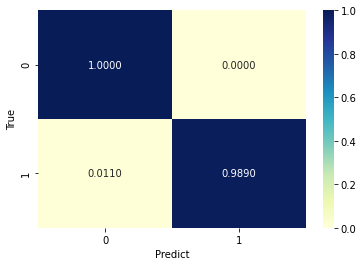

In [ ]:
model_scores = fit_and_score(models={"Logistic Regression":LogisticRegression(C=0.1,max_iter = 4)},
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

Regressão logística aparentemente é muito boa para prever os verdadeiros negativos

### 6.2.2) Knearest Neighbors

{'KNN': 0.936}

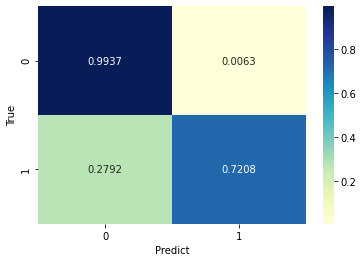

In [ ]:
model_scores = fit_and_score(models={"KNN": KNeighborsClassifier()},
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

In [ ]:
# Cross-validated accuracy
cv_acc_knn = cross_val_score(knn,
                         X,
                         y,
                         cv=5,
                         scoring="accuracy")
cv_acc_knn

array([0.93533333, 0.93197733, 0.94431477, 0.92864288, 0.93731244])

In [ ]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

{'KNN': 0.926}

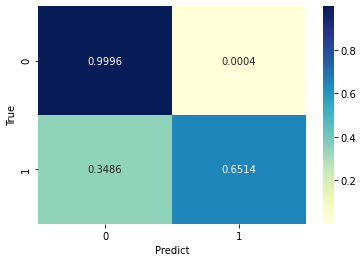

In [ ]:
model_scores = fit_and_score(models={"KNN": KNeighborsClassifier(n_neighbors=12)},
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

Esse algoritmo tem muitos passos negativos, não é muito bom para o nosso caso

### 6.2.3) Random Forest

{'Random Forest': 0.999}

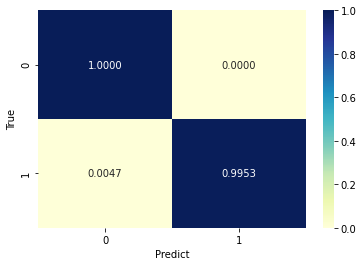

In [ ]:
np.random.seed(1)
model_scores = fit_and_score(models={"Random Forest": RandomForestClassifier()},
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

In [ ]:
# Cross-validated accuracy
cv_acc_rf = cross_val_score(rf,
                         X,
                         y,
                         cv=5,
                         scoring="accuracy")
cv_acc_rf

array([0.99966667, 0.99833278, 0.996999  , 0.99333111, 0.99799933])

### 6.2.4) SVM

{'SVM Classifier': 1.0}

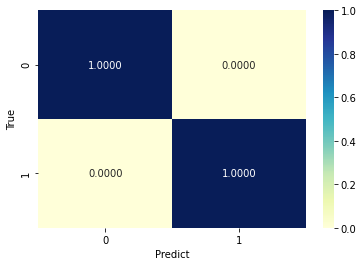

In [ ]:
model_scores = fit_and_score(models={"SVM Classifier": svm.SVC(kernel='linear')},
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

In [ ]:
# Cross-validated accuracy
cv_acc_rf = cross_val_score(svc,
                         X,
                         y,
                         cv=5,
                         scoring="accuracy")
cv_acc_rf

array([1., 1., 1., 1., 1.])

De acordo com os resultados acima, o melhor que se saiu foi o Random Forest regressão logística e o SVM, mas apenas a Regressão logistica retorna uma probabilidade de 

## 6.3) Treinando o Modelo

Vamos criar uma função que retorna as métricas do modelo

In [ ]:
def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {"accuracy": round(accuracy, 4),
                   "precision": round(precision, ),
                   "recall": round(recall, 4),
                   "f1": round(f1, 4)}
    print(f"Acc: {accuracy * 100:.4f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 score: {f1:.4f}")
    
    return metric_dict

Para resumir as métricas de classificação:

* A acurácia (accuracy) é uma boa medida para medir se todas as classes estão balanceadas (por exemplo, mesma quantidade de amostras que são marcadas com 0 ou 1).
* Precisão (Precision) e recall tornam-se mais importantes quando as classes estão desequilibradas.
  * Se as previsões de falsos positivos forem piores do que os falsos negativos, busque maior precisão.
  * Se as previsões de falsos negativos forem piores do que os falsos positivos, busque maior recall.
* A F1-score é uma combinação de precisão e recuperação.

Agora vamos treinar o modelo

In [ ]:
np.random.seed(42)
#Training the model
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)

# Make baseline predictions
y_preds_rf = clf_rf.predict(X_test)

# Evaluate the classifier on validation set
baseline_metrics = evaluate_preds(y_test, y_preds_rf)

Acc: 99.9000%
Precision: 1.0000
Recall: 0.9953
F1 score: 0.9976


In [ ]:
np.random.seed(42)
#Training the model
clf_lr = LogisticRegression(C=0.1,max_iter = 3)
clf_lr.fit(X_train, y_train)

# Make baseline predictions
y_preds_lr = clf_lr.predict(X_test)

# Evaluate the classifier on validation set
baseline_metrics_lr = evaluate_preds(y_test, y_preds_lr);

Acc: 98.7667%
Precision: 1.0000
Recall: 0.9416
F1 score: 0.9699


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## 6.4) Hyperparameter tunning

### 6.4.1) Tuning hyperparameters by hand


In [ ]:
clf_lr = LogisticRegression(max_iter = 3)
clf_rf = RandomForestClassifier()

Vamos ajustar os seguintes parâmetros para o Random Forest:

* `max_depth`
* `max_features`
* `min_samples_leaf`
* `min_samples_split`
* `n_estimators`

E os seguintes para a Regressão logística
* `C`
* `max_iter`

In [ ]:
np.random.seed(42)

clf_rf.fit(X_train, y_train)

# Make baseline predictions
y_preds = clf_rf.predict(X_test)

# Evaluate the classifier on validation set
baseline_metrics_rf = evaluate_preds(y_test, y_preds)
baseline_metrics_rf

Acc: 99.9000%
Precision: 1.0000
Recall: 0.9953
F1 score: 0.9976


{'accuracy': 0.999, 'f1': 0.9976, 'precision': 1.0, 'recall': 0.9953}

In [ ]:
np.random.seed(42)

clf_lr.fit(X_train, y_train)

# Make baseline predictions
y_preds = clf_lr.predict(X_test)

# Evaluate the classifier on validation set
baseline_metrics_lr = evaluate_preds(y_test, y_preds)
baseline_metrics_lr

Acc: 98.8667%
Precision: 1.0000
Recall: 0.9464
F1 score: 0.9724


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'accuracy': 0.9887, 'f1': 0.9724, 'precision': 1.0, 'recall': 0.9464}

Fazendo uma leve mudança nos `n_estimators`

In [ ]:
np.random.seed(42)

# Create a second classifier with different hyperparameters
clf_2 =LogisticRegression(C = 0.1, max_iter=4)
clf_2.fit(X_train, y_train)

# Make predictions with different hyperparameters
y_preds_2 = clf_2.predict(X_test)

# Evalute the 2nd classsifier
clf_2_metrics = evaluate_preds(y_test, y_preds_2)

Acc: 99.7667%
Precision: 1.0000
Recall: 0.9890
F1 score: 0.9944


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 6.4.2) Hyperparameter tuning com RandomizedSearchCV

In [ ]:
np.random.seed(42)

grid_lr = {'C' : [0.1,1.0],
        "max_iter": [3, 4, 5,6]}

# Instantiate Logistic Regression
clf_lr = LogisticRegression()

# Setup RandomizedSearchCV
rs_clf_lr = RandomizedSearchCV(estimator=clf_lr,
                            param_distributions=grid_lr, 
                            n_iter=10, # number of models to try
                            cv=5,
                            verbose=2)

# Fit the RandomizedSearchCV version of clf
rs_clf_lr.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/skl

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] max_iter=3, C=0.1 ...............................................
[CV] ................................ max_iter=3, C=0.1, total=   0.0s
[CV] max_iter=3, C=0.1 ...............................................
[CV] ................................ max_iter=3, C=0.1, total=   0.0s
[CV] max_iter=3, C=0.1 ...............................................
[CV] ................................ max_iter=3, C=0.1, total=   0.0s
[CV] max_iter=3, C=0.1 ...............................................
[CV] ................................ max_iter=3, C=0.1, total=   0.0s
[CV] max_iter=3, C=0.1 ...............................................
[CV] ................................ max_iter=3, C=0.1, total=   0.0s
[CV] max_iter=4, C=0.1 ...............................................
[CV] ................................ max_iter=4, C=0.1, total=   0.0s
[CV] max_iter=4, C=0.1 ...............................................
[CV] ............

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] ................................ max_iter=5, C=0.1, total=   0.0s
[CV] max_iter=5, C=0.1 ...............................................
[CV] ................................ max_iter=5, C=0.1, total=   0.0s
[CV] max_iter=5, C=0.1 ...............................................
[CV] ................................ max_iter=5, C=0.1, total=   0.0s
[CV] max_iter=6, C=0.1 ...............................................
[CV] ................................ max_iter=6, C=0.1, total=   0.0s
[CV] max_iter=6, C=0.1 ...............................................
[CV] ................................ max_iter=6, C=0.1, total=   0.0s
[CV] max_iter=6, C=0.1 ...............................................
[CV] ................................ max_iter=6, C=0.1, total=   0.0s
[CV] max_iter=6, C=0.1 ...............................................
[CV] ................................ max_iter=6, C=0.1, total=   0.0s
[CV] max_iter=6, C=0.1 ...............................................
[CV] .

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] ................................ max_iter=3, C=1.0, total=   0.0s
[CV] max_iter=4, C=1.0 ...............................................
[CV] ................................ max_iter=4, C=1.0, total=   0.0s
[CV] max_iter=4, C=1.0 ...............................................
[CV] ................................ max_iter=4, C=1.0, total=   0.0s
[CV] max_iter=4, C=1.0 ...............................................
[CV] ................................ max_iter=4, C=1.0, total=   0.0s
[CV] max_iter=4, C=1.0 ...............................................
[CV] ................................ max_iter=4, C=1.0, total=   0.0s
[CV] max_iter=4, C=1.0 ...............................................
[CV] ................................ max_iter=4, C=1.0, total=   0.0s
[CV] max_iter=5, C=1.0 ...............................................
[CV] ................................ max_iter=5, C=1.0, total=   0.0s
[CV] max_iter=5, C=1.0 ...............................................
[CV] .

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
grid_rf = {"n_estimators": [10, 100, 200, 500, 1000, 1200],
        "max_depth": [None, 5, 10, 20, 30],
        "max_features": ["auto", "sqrt"],
        "min_samples_split": [2, 4, 6],
        "min_samples_leaf": [1, 2, 4]}

np.random.seed(42)

# Instantiate RandomForestClassifier
clf_rf = RandomForestClassifier(n_jobs=1)

# Setup RandomizedSearchCV
rs_clf_rf = RandomizedSearchCV(estimator=clf_rf,
                            param_distributions=grid_rf, 
                            n_iter=10, # number of models to try
                            cv=5,
                            verbose=2)

# Fit the RandomizedSearchCV version of clf
rs_clf_rf.fit(X_train, y_train);

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=100, min_samples_split=6, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=6, min_samples_leaf=1, max_features=auto, max_depth=10, total=   0.9s
[CV] n_estimators=100, min_samples_split=6, min_samples_leaf=1, max_features=auto, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=6, min_samples_leaf=1, max_features=auto, max_depth=10, total=   0.9s
[CV] n_estimators=100, min_samples_split=6, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=6, min_samples_leaf=1, max_features=auto, max_depth=10, total=   0.9s
[CV] n_estimators=100, min_samples_split=6, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=6, min_samples_leaf=1, max_features=auto, max_depth=10, total=   0.9s
[CV] n_estimators=100, min_samples_split=6, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=6, min_samples_leaf=1, max_features=auto, max_depth=10, total=   0.9s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, total=   1.9s
[CV] n_estimators=100, min_samples_split=2, min_

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  7.2min finished


In [ ]:
rs_clf_lr.best_params_

{'C': 0.1, 'max_iter': 5}

In [ ]:
rs_clf_rf.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 200}

In [ ]:
# Make predictions with the best hyperparameters
rs_y_preds_lr = rs_clf_lr.predict(X_test)

# Evaluate the predictions
rs_metrics_lr = evaluate_preds(y_test, rs_y_preds_lr)

Acc: 100.0000%
Precision: 1.0000
Recall: 1.0000
F1 score: 1.0000


In [ ]:
# Make predictions with the best hyperparameters
rs_y_preds_rf = rs_clf_rf.predict(X_test)

# Evaluate the predictions
rs_metrics_rf = evaluate_preds(y_test, rs_y_preds_rf)

Acc: 99.0667%
Precision: 1.0000
Recall: 0.9558
F1 score: 0.9774


### 5.3 Hyperparameter tuning with GridSearchCV

In [ ]:
grid_2 = {'n_estimators': [100, 200, 500],
          'max_depth': [None],
          'max_features': ['auto', 'sqrt'],
          'min_samples_split': [6],
          'min_samples_leaf': [1, 2]}

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split

np.random.seed(42)


# Setup GridSearchCV
gs_clf_rf = GridSearchCV(estimator=clf_rf,
                       param_grid=grid_2, 
                       cv=5,
                       verbose=2)

# Fit the GridSearchCV version of clf
gs_clf_rf.fit(X_train, y_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100, total=   3.2s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100, total=   3.3s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100, total=   3.0s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100, total=   3.1s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100, total=   3.1s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200, total=   6.1s
[CV] max_depth=None, max_features=

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  6.6min finished


In [ ]:
gs_clf_rf.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 500}

In [ ]:
gs_y_preds = gs_clf_rf.predict(X_test)

# evaluate the predictions
gs_metrics = evaluate_preds(y_test, gs_y_preds)

Acc: 99.9000%
Precision: 1.0000
Recall: 0.9953
F1 score: 0.9976


Vamos comparar as métricas para os diferntes hyperparameter tunning para o Random Forest

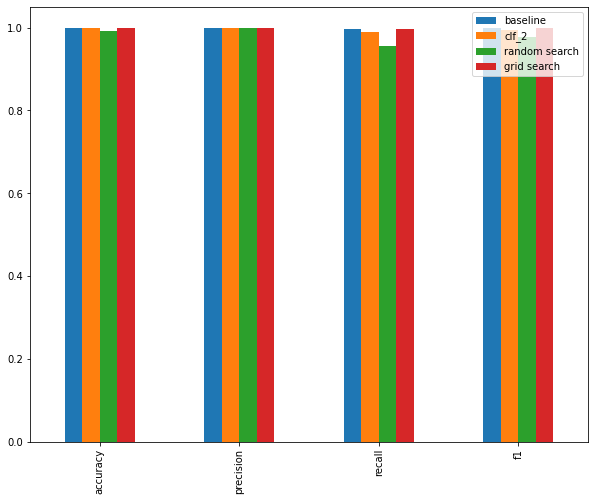

In [ ]:
compare_metrics = pd.DataFrame({"baseline": baseline_metrics,
                                "clf_2": clf_2_metrics,
                                "random search": rs_metrics_rf,
                                "grid search": gs_metrics})

compare_metrics.plot.bar(figsize=(10, 8));

Pela análise acima, a diferença entre o Random Forest com parâmetros diferentes é muito pouca. O modelo basal já é bastante eficiente.

# 7) Predição da probabilidade

FInalmente, vamos calcular a probabilidade de um cliente estar na categoria predita. Para isso, teremos que usar o Modelo de regressão logística, pois ele tem uma função que retorna a probabilidade do clinete pertecencer a uma classe.

No final, ficamos com a `LogisticRegression( C=0.1, max_iter = 5)`

In [ ]:
np.random.seed(42)
model = LogisticRegression( C=0.1, max_iter = 5)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
y_true = y_test
cm = confusion_matrix(y_true, y_pred).astype(int)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


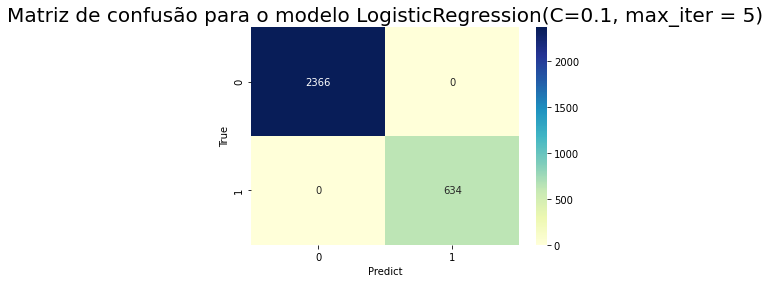

In [ ]:
sns.heatmap(cm, annot=True, fmt ='d',cmap="YlGnBu")
plt.xlabel('Predict')
plt.ylabel('True')
plt.title('Matriz de confusão para o modelo LogisticRegression(C=0.1, max_iter = 5)', fontsize=20);


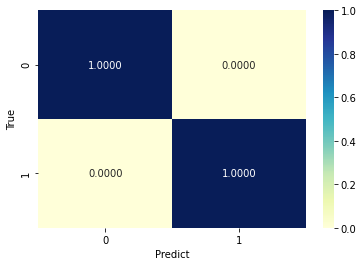

In [ ]:

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt ='.4f',cmap="YlGnBu")
plt.xlabel('Predict')
plt.ylabel('True');

In [ ]:
y_proba[:5]

array([[0.91433031, 0.08566969],
       [0.84584908, 0.15415092],
       [0.07791884, 0.92208116],
       [0.90865534, 0.09134466],
       [0.88665172, 0.11334828]])

A probabilidade é um array onde



```
[ probabilidade de estar na classe 0, probabilidade de estar na classe 1]
```




In [ ]:
y_p = model.predict_proba(X)

In [ ]:
y_p.shape

(14996, 2)

In [ ]:
y_p

array([[0.93399127, 0.06600873],
       [0.92978542, 0.07021458],
       [0.93552826, 0.06447174],
       ...,
       [0.93446705, 0.06553295],
       [0.94132065, 0.05867935],
       [0.91985056, 0.08014944]])

In [ ]:
#Probabilidade de pertencer a classe um, ou seja, ser aprovado
y_p[:,1]

array([0.06600873, 0.07021458, 0.06447174, ..., 0.06553295, 0.05867935,
       0.08014944])

# Salvando modelo para uso posterior

In [ ]:
import pickle

# Save an extisting model to file
pickle.dump(rs_clf_lr, open("rs_logistic_regression_model.pkl", "wb"))

In [ ]:
# Load a saved model
loaded_pickle_model = pickle.load(open("rs_logistic_regression_model.pkl", "rb"))

In [ ]:
pickle_y_preds = loaded_pickle_model.predict(X)
pickle_y_pred_proba = loaded_pickle_model.predict_proba(X)

In [ ]:
prob_aprovado =  pickle_y_pred_proba[:,1]

## COMO USAR ESSE NOTEBOOK

Para usar esse notebook para seu dataset, além de limpar seus dados, deve-se separar as seguintes features


```
['age', 'monthly_income', 'collateral_value', 'loan_amount', 'state',
'collateral_debt', 'verified_restriction', 'dishonored_checks',
'expired_debts', 'banking_debts', 'commercial_debts', 'protests',
'informed_restriction', 'monthly_payment', 'auto_brand', 'auto_model',
'auto_year', 'form_completed', 'sent_to_analysis', 'gender','education_level', 
'income_cat', 'payment_cat', 'informed_cat']
```

Uma vez que seus dados estiverem selecionados, tem que preprocessar com a Pipeline



```
num_pipeline = Pipeline([('min_max', MinMaxScaler())])

num_attribs = list(pre_approv_num)

cat_attribs = ["state", "auto_brand", "auto_model","gender",'education_level','income_cat','payment_cat']

full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs),("cat", OneHotEncoder(), cat_attribs)])
```

Finalmente, a probabilidade é calculada utilizando
você pode usar o modelo treinado nesse caderno carrengando-o na sua máquina utilizando o cmando abaixo

```
import pickle
X = seu_dataset_sem_sent_to_analysis
path = "../rs_logistic_regression_model.pkl"
loaded_pickle_model = pickle.load(open(path, "rb"))
```
Agora o `loaded_pickle_model` funciona como um modelo treinado e que pode se fazer predições
```
pickle_y_preds = loaded_pickle_model.predict(X)
pickle_y_pred_proba = loaded_pickle_model.predict_proba(X)
```
O `pickle_y_pred_proba` é um array da seguinte forma

```
[[ probabilidade de estar na classe 0, probabilidade de estar na classe 1],....]
```

